## This notebook loads the clusterd sequences (resutls from "Read_and_cluster.ipynb") and merges data of chosen behavioral epochs (merge sampling, outward, reward) in order to  perform furthur repaly analysis using bayesina decoder.

In [32]:
import matplotlib.pyplot as plt
import numpy as np
from os.path import join
from scipy.ndimage import gaussian_filter1d
from scipy.special import factorial
from scipy.stats import spearmanr
import pftools as pf
import configparser
import os
import matplotlib as mpl
# Initialize the configuration parser
config = configparser.ConfigParser()

# Read the configuration file
#config.read('config.ini')

# Get the data folder path from the config file
#savefolder= config['paths']['savefolder']
plt.rcParams.update({'font.size': 16})
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['xtick.labelsize'] = 16  # You can adjust the font size as needed
plt.rcParams['ytick.labelsize'] = 16  # You can adjust the font size as needed
import mtools as mot
import pickle
from scipy.stats import mode
from scipy.stats import pearsonr

import matplotlib.pyplot as plt

In [33]:
import configparser
import os
from pathlib import Path
onfig = configparser.ConfigParser()
# Detect base directory
try:
    BASE_DIR = Path(__file__).resolve().parent  # For scripts
except NameError:
    BASE_DIR = Path.cwd()  # For Jupyter Notebooks

# Move one level up
BASE_DIR = BASE_DIR.parent

# Load config.ini
config = configparser.ConfigParser()
config.read(os.path.join(os.getcwd(), "config.ini"))

# Construct full paths using pathlib and ensure they end with a separator
skeletonsfolder = str((BASE_DIR / config["paths"]["skeletonsfolder"]).resolve()) + os.sep
savefolder = str((BASE_DIR / config["paths"]["savefolder"]).resolve()) + os.sep
datafolder = str((BASE_DIR / config["paths"]["datafolder"]).resolve()) + os.sep

# Print paths to verify
print("Base Directory:", BASE_DIR)
print("Skeletons Folder:", skeletonsfolder)
print("Save Folder:", savefolder)
print("Data Folder:", datafolder)

Base Directory: c:\Users\hamed\Desktop\Hamed\Github\TP7
Skeletons Folder: C:\Users\hamed\Desktop\Hamed\Github\TP7\data\GCaMP6f_478-485\skeleton\
Save Folder: C:\Users\hamed\Desktop\Hamed\Github\TP7\results_new\
Data Folder: C:\Users\hamed\Desktop\Hamed\Github\TP7\data\GCaMP6f_478-485\


In [3]:
cond_names = {
    'sampling_L': 0,
    'sampling_R': 1,
    'outward_L': 2,
    'outward_R': 3,
    'reward_L': 4,
    'reward_R': 5,
    'inward_L': 6,
    'inward_R': 7
}

In [37]:
cond_names = {
 'arena_outward_L': 8,
 'arena_outward_R': 9,
 'arena_inward_L': 10,
 'arena_inward_R': 11
}

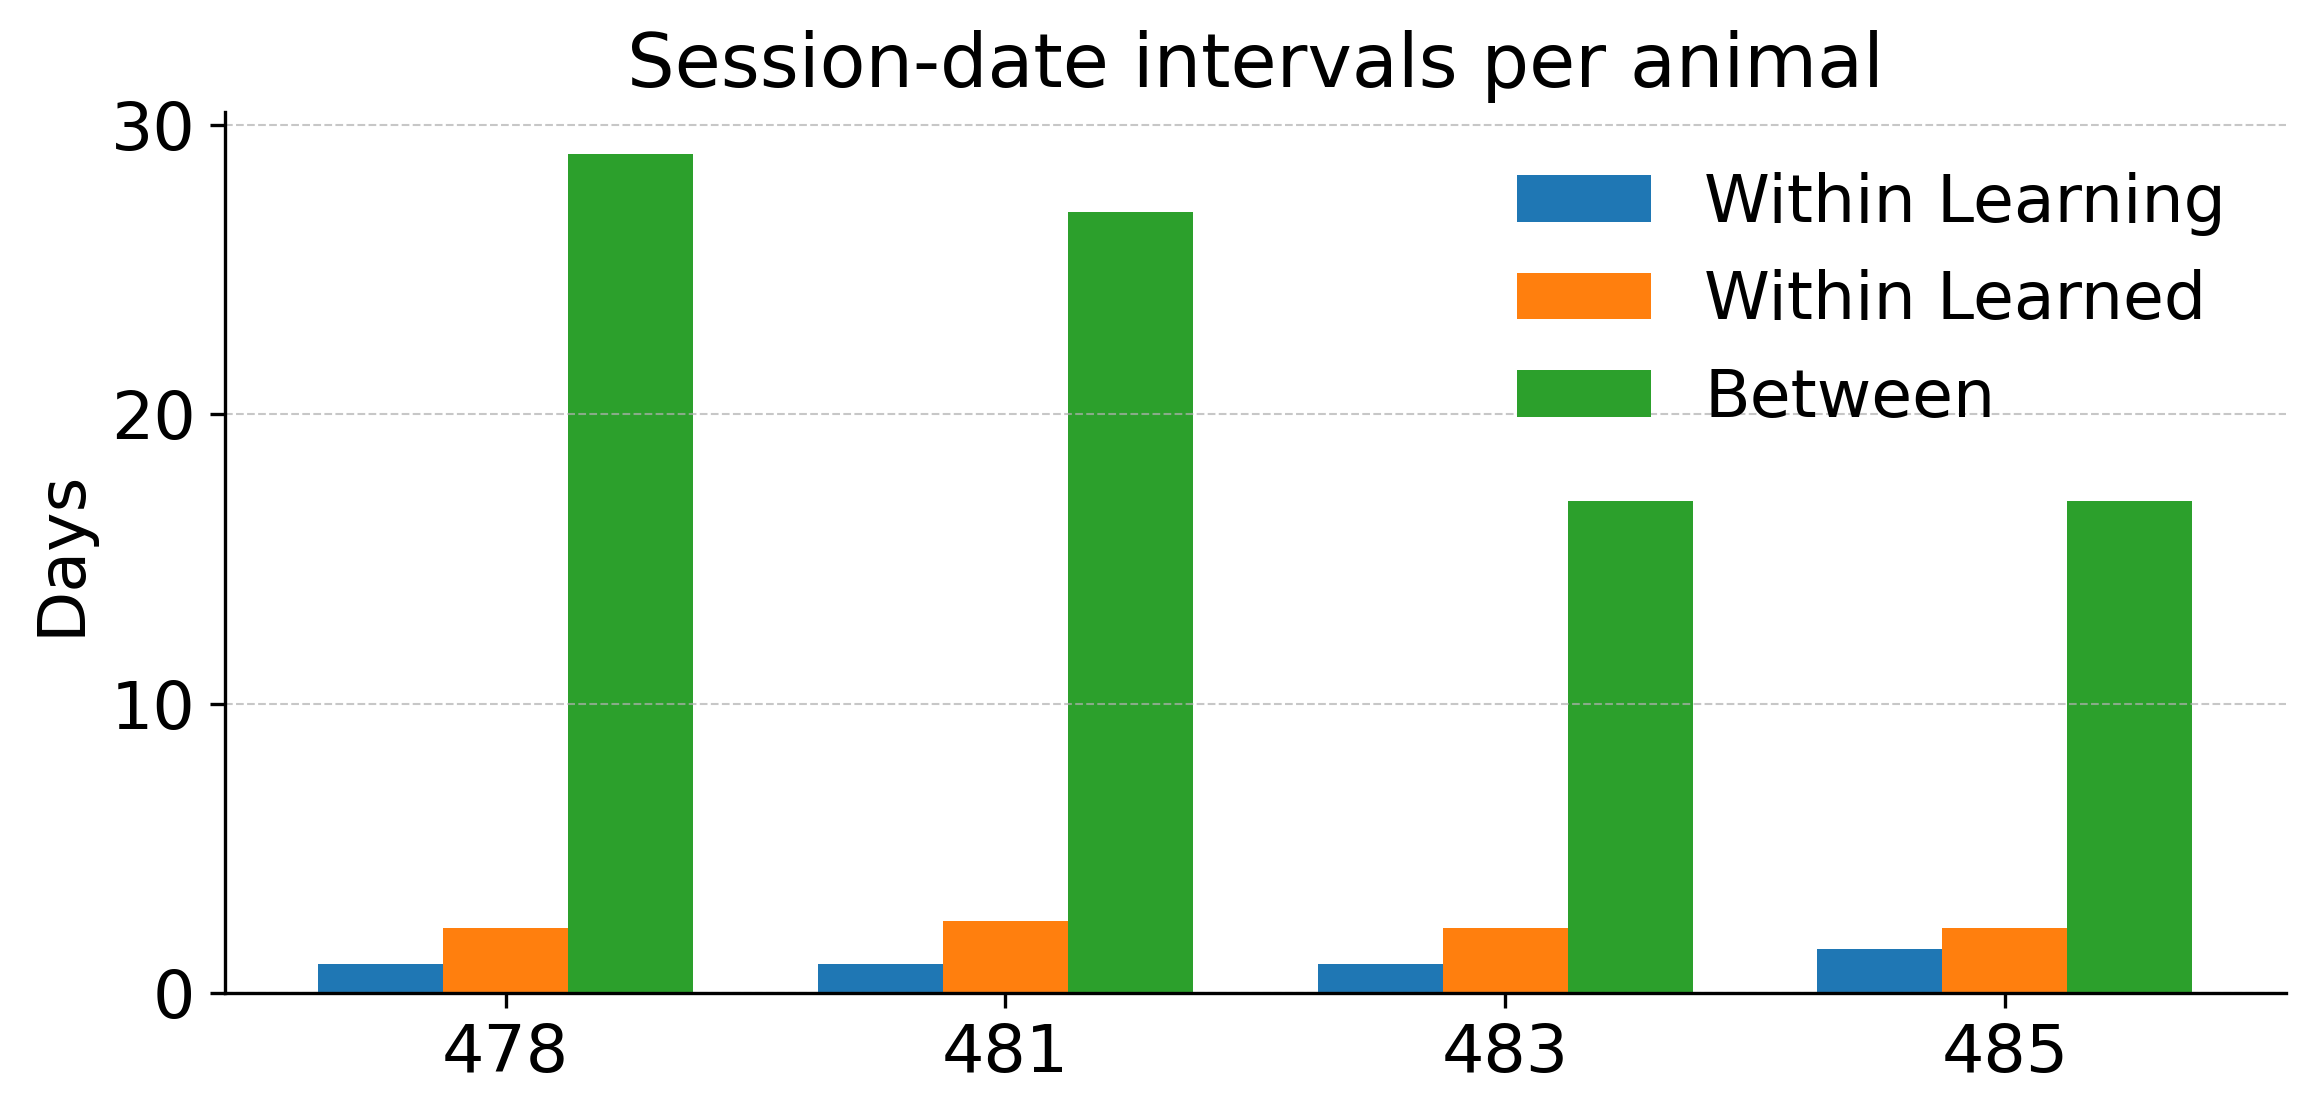

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from os.path import join

cell_types   = 'All'
descriotor   = 'No_chunk_0.5s_transients'
animals      = ['478','481','483','485']
results      = {}

for fol in animals:
    # ─────── your existing loading code ───────────────────────────────────────
    filename       = fol + 'Sesseion_info_All AllNo_chunk_0.5s_transients'
    data_all_tasks = np.load(join(savefolder, filename), allow_pickle=True)
    sess_info      = data_all_tasks['sess_info']

    filename_mask  = fol + 'Mask_with_correct_cells'
    Masks_         = np.load(join(savefolder, filename_mask), allow_pickle=True)
    Masks          = Masks_[0]

    session_mask   = Masks_[1]   # <-- this is your dict of filenames → session idx
    # ────────────────────────────────────────────────────────────────────────────

    # parse dates & phases from the filenames
    entries = []
    for fname in session_mask.keys():
        # first 8 chars are YYYYMMDD
        dt    = datetime.strptime(fname[:8], '%Y%m%d')
        phase = 'learning' if '_task_learning' in fname else 'learned'
        entries.append((dt, phase))
    entries.sort(key=lambda x: x[0])

    # separate out just the dates
    learning_dates = [dt for dt,ph in entries if ph == 'learning']
    learned_dates  = [dt for dt,ph in entries if ph == 'learned']

    # helper to get mean interval in days between consecutive dates
    def mean_interval(dates):
        if len(dates) < 2:
            return np.nan
        diffs = np.diff([d.timestamp() for d in dates]) / 86400.0
        return diffs.mean()

    within_learning = mean_interval(learning_dates)
    within_learned  = mean_interval(learned_dates)
    # between last learning and first learned
    if learning_dates and learned_dates:
        between = (learned_dates[0] - learning_dates[-1]).days
    else:
        between = np.nan

    results[fol] = {
        'within_learning_days': within_learning,
        'within_learned_days':  within_learned,
        'between_days':         between
    }

# ──────────────── now visualize across all animals ───────────────────────────
metrics = ['within_learning_days','within_learned_days','between_days']
labels  = ['Within Learning','Within Learned','Between']
data    = np.array([[results[a][m] for m in metrics] for a in animals])

x     = np.arange(len(animals))
width = 0.25

fig, ax = plt.subplots(figsize=(8,4))
for i, lab in enumerate(labels):
    ax.bar(x + (i-1)*width, data[:,i], width, label=lab)

ax.set_xticks(x)
ax.set_xticklabels(animals)
ax.set_ylabel('Days')
ax.set_title('Session‐date intervals per animal')
ax.legend(frameon=False)

# publication styling
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.show()


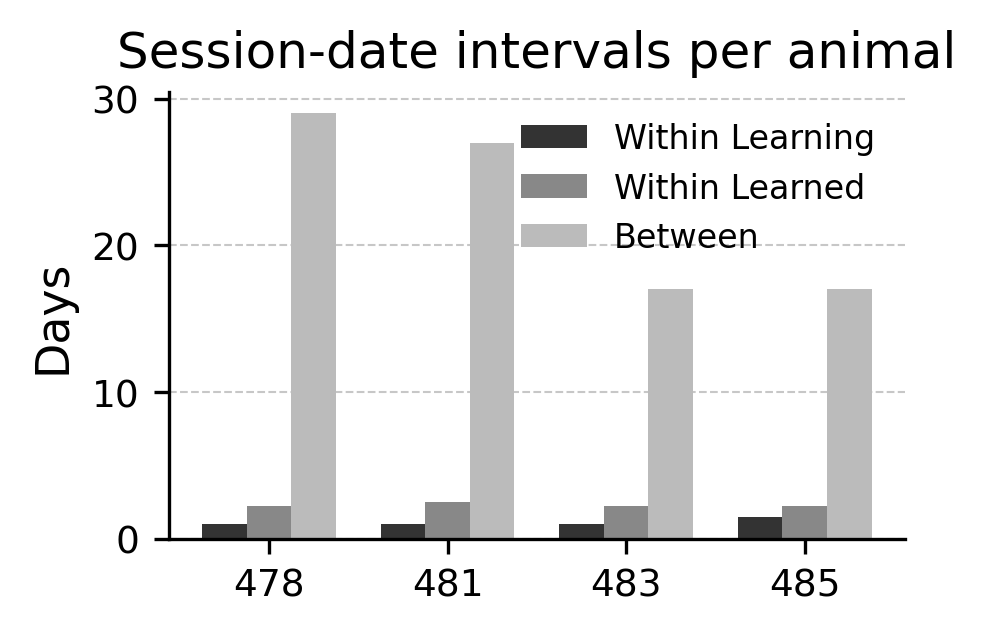

In [7]:

metrics = ['within_learning_days','within_learned_days','between_days']
labels  = ['Within Learning','Within Learned','Between']

# build data array
data = np.array([[results[a][m] for m in metrics] for a in animals])

# ─────── Publication‐style settings ─────────────────────────────────────────
plt.rcParams.update({
    'font.family':     'sans-serif',
    'font.size':       10,
    'axes.labelsize':  11,
    'axes.titlesize':  12,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'legend.fontsize': 8,
    'figure.dpi':      300,
    'axes.linewidth':  0.8,
})

fig, ax = plt.subplots(figsize=(3,2), constrained_layout=True)

x     = np.arange(len(animals))
width = 0.25
# Three levels of grey
colors = ['#333333', '#888888', '#BBBBBB']

for i, (lab, col) in enumerate(zip(labels, colors)):
    ax.bar(x + (i-1)*width, data[:,i], width,
           label=lab, color=col, edgecolor='none')

ax.set_xticks(x)
ax.set_xticklabels(animals)
ax.set_ylabel('Days')
ax.set_title('Session‐date intervals per animal')

# clean up spines and add grid
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
ax.set_axisbelow(True)

ax.legend(frameon=False, loc='upper right')

# Save as SVG for publication
save_path = join(savefolder, 'session_intervals.svg')
fig.savefig(save_path, format='svg', bbox_inches='tight')

In [130]:
session_mask={'20220215_gcamp6f481_task_learning.mat': 0,
 '20220216_gcamp6f481_task_learning.mat': 1,
 '20220217_gcamp6f481_task_learning.mat': 2,
 '20220218_gcamp6f481_task_learning.mat': 3,
 '20220317_gcamp6f481_task_learned.mat': 4,
 '20220318_gcamp6f481_task_learned.mat': 5,
 '20220319_gcamp6f481_task_learned.mat': 6,
 '20220320_gcamp6f481_task_learned.mat': 7,
 '20220327_gcamp6f481_task_learned.mat': 8,
 '20220201_gcamp6f481_arena.mat': 10,
 '20220202_gcamp6f481_arena.mat': 11,
 '20220203_gcamp6f481_arena.mat': 12}

In [176]:
def apply_masks_arena(sess_info, Masks, cond_numbers, cond_name, sessin_numbers, sess_name):
    """
    Apply masks to session data to extract data for a specific condition and session.

    This function filters the session information (in `sess_info`) using boolean masks from
    the `Masks` dictionary. Data is selected based on:
      - Condition (e.g., outward, inward) via `cond_numbers` and `cond_name`
      - Session number via `sessin_numbers` and `sess_name`
      - Speed threshold criteria (not used for the manuscript)

    The filtered data is returned in a dictionary (`run_data`) containing:
      - Cluster IDs, burst peak indices, sequences, burst events
      - Single-cell spike times and condition labels for cells
      - Trial indices, time vectors, population rates, raw cell traces, position data,
        spatial coordinates, speed, and firing rates
      - Session and condition names

    Parameters
    ----------
    sess_info : dict
        Session information. Keys include:
        'Spike_times_cells', 'id_peaks', 'seqs', 'bursts', 'trial_idx_mask',
        't', 'pop_rate', 'extract', 'lin_pos', 'xloc', 'yloc', 'speed', 'fr', etc.
    Masks : dict
        Boolean masks for filtering. Keys include:
        'phases', 'bursts_phase', 'fr_phase', 'bursts_sess', 'sessions', 'fr_sess',
        'cell_phase', 'cell_sess', 'bursts_cond', 'conditions', 'fr_cond',
        'cell_cond', 'speed_seq', 'speed'
    cond_numbers : list or array-like
        Condition identifiers to include (e.g., [3] for outward).
    cond_name : dict
        Maps numeric condition IDs to human‐readable names.
    sessin_numbers : list or array-like
        Session numbers to include.
    sess_name : dict
        Maps session numbers to session file‐name strings.

    Returns
    -------
    run_data : dict
        Filtered session data with keys:
        'idpeaks_cells', 'mask_cond_fr_cells', 'ids_clust', 'idpeaks', 'seqs', 'bursts',
        'mask_cond_fr', 'trial_idx_mask', 't', 'poprate', 'trace_cells', 'lin_pos',
        'conditions', 'x_loc', 'y_loc', 'speed', 'fr', 'spike_idx', 'spike_idx_cells',
        'sess_name', 'cond_name'.
    """
    # Initialize output
    run_data = {
        'idpeaks_cells': [[] for _ in range(len(sess_info['Spike_times_cells']))],
        'mask_cond_fr_cells': [[] for _ in range(len(sess_info['Spike_times_cells']))]
    }

    # ~~~~~~ Session Masks ~~~~~~
    mask_sess_burst = np.zeros_like(np.asarray(Masks['bursts_sess']), dtype=bool)
    mask_sess_t = np.zeros_like(np.asarray(Masks['sessions']), dtype=bool)
    mask_sess_fr = np.zeros_like(np.asarray(Masks['fr_sess']), dtype=bool)
    sess_names = ''

    for sess_nbr in sessin_numbers:
        mask_sess_burst |= np.asarray(Masks['bursts_sess']) == sess_nbr
        mask_sess_t     |= np.asarray(Masks['sessions'])    == sess_nbr
        mask_sess_fr    |= np.asarray(Masks['fr_sess'])     == sess_nbr
        # pull human name (strip extension)
        print(sess_name)
        #sess_key = list(sess_name.keys())[sess_nbr]


        sess_names_inv = {v: k for k, v in sess_name.items()}
        sess_name_ = sess_names_inv.get(sess_nbr)



        sess_names += ' and ' + sess_name_[:-4]

    mask_sess_cell = [
        np.zeros_like(np.asarray(x), dtype=bool)
        for x in Masks['cell_sess']
    ]
    for celid in range(len(mask_sess_cell)):
        for sess_nbr in sessin_numbers:
            mask_sess_cell[celid] |= np.asarray(Masks['cell_sess'][celid]) == sess_nbr

    # ~~~~~~ Condition Masks ~~~~~~
    mask_cond_burst = np.zeros_like(np.asarray(Masks['bursts_cond']), dtype=bool)
    mask_cond_t     = np.zeros_like(np.asarray(Masks['conditions']), dtype=bool)
    mask_cond_fr    = np.zeros_like(np.asarray(Masks['fr_cond']), dtype=bool)
    cond_names = ''

    inv_cond = {v: k for k, v in cond_name.items()}
    for cond_nbr in cond_numbers:
        mask_cond_burst |= np.asarray(Masks['bursts_cond']) == cond_nbr
        mask_cond_t     |= np.asarray(Masks['conditions'])  == cond_nbr
        mask_cond_fr    |= np.asarray(Masks['fr_cond'])     == cond_nbr
        # lookup name
        name = inv_cond.get(cond_nbr)
       # cond_names += ' and ' + name

    mask_cond_cell = [
        np.zeros_like(x, dtype=bool)
        for x in Masks['cell_cond']
    ]
    for celid in range(len(mask_cond_cell)):
        for cond_nbr in cond_numbers:
            mask_cond_cell[celid] |= np.asarray(Masks['cell_cond'][celid]) == cond_nbr

    # ~~~~~~ Extract bursts & sequences ~~~~~~
    run_data['ids_clust'] = np.asarray(sess_info['ids_clust'])[
        mask_sess_burst & mask_cond_burst & Masks['speed_seq']
    ]
    run_data['idpeaks'] = np.asarray(sess_info['id_peaks'])[
        mask_sess_burst & mask_cond_burst & Masks['speed_seq']
    ]
    run_data['seqs'] = np.asarray(sess_info['seqs'])[
        mask_sess_burst & mask_cond_burst & Masks['speed_seq']
    ]
    run_data['bursts'] = np.asarray(sess_info['bursts'])[
        mask_sess_burst & mask_cond_burst & Masks['speed_seq']
    ]
    run_data['mask_cond_fr'] = np.asarray(Masks['bursts_cond'])[
        mask_sess_burst & mask_cond_burst & Masks['speed_seq']
    ]

    # ~~~~~~ Cell‐specific data ~~~~~~
    for celid in range(len(sess_info['Spike_times_cells'])):
        run_data['idpeaks_cells'][celid] = np.asarray(sess_info['Spike_times_cells'][celid])[  # spike times
            mask_sess_cell[celid] & mask_cond_cell[celid]
        ]
        run_data['mask_cond_fr_cells'][celid] = np.asarray(Masks['cell_cond'][celid])[      # cond labels
            mask_sess_cell[celid] & mask_cond_cell[celid]
        ]

    # ~~~~~~ Time‐series, population & positions ~~~~~~
    combined_t_mask = mask_sess_t & mask_cond_t & Masks['speed']
    run_data['trial_idx_mask'] = np.asarray(sess_info['trial_idx_mask'])[combined_t_mask]
    run_data['t']               = np.asarray(sess_info['t'])[combined_t_mask]
    run_data['poprate']         = np.asarray(sess_info['pop_rate'])[combined_t_mask]
    run_data['trace_cells']     = np.asarray([
        x[combined_t_mask] for x in sess_info['extract']
    ])
    run_data['lin_pos']   = np.asarray(sess_info['lin_pos'])[combined_t_mask]
    run_data['conditions'] = np.asarray(Masks['conditions'])[combined_t_mask]
    run_data['x_loc']     = np.asarray(sess_info['xloc'])[combined_t_mask]
    run_data['y_loc']     = np.asarray(sess_info['yloc'])[combined_t_mask]
    run_data['speed']     = np.asarray(sess_info['speed'])[combined_t_mask]

    # ~~~~~~ Firing rates ~~~~~~
    run_data['fr'] = np.asarray(sess_info['fr'])[
        mask_sess_fr & mask_cond_fr
    ]

    # ~~~~~~ Spike‐index alignment ~~~~~~
    t_all = np.asarray(sess_info['t'])[mask_sess_t & mask_cond_t]
    spk_times       = np.where(np.isin(t_all, run_data['idpeaks']))
    spk_times_cell  = [np.where(np.isin(t_all, x)) for x in run_data['idpeaks_cells']]

    run_data['spike_idx']       = spk_times
    run_data['spike_idx_cells'] = spk_times_cell

    # ~~~~~~ Meta‐info ~~~~~~
    run_data['sess_name'] = sess_names
    run_data['cond_name'] = cond_names

    return run_data


In [171]:
 list(sess_names.keys())


AttributeError: 'str' object has no attribute 'keys'

In [141]:
cond_name

{'arena_outward_L': 8,
 'arena_outward_R': 9,
 'arena_inward_L': 10,
 'arena_inward_R': 11}

In [142]:
cond_numbers

[9]

In [143]:
name_of_conds

NameError: name 'name_of_conds' is not defined

In [144]:
cond_numbers

[9]

In [147]:
cond_numbers

[8, 9, 10, 11]

In [148]:
cond_name_inv

{8: 'arena_outward_L',
 9: 'arena_outward_R',
 10: 'arena_inward_L',
 11: 'arena_inward_R'}

In [209]:
sessin_numbers

[10, 11, 12]

In [211]:
# your session → index mapping
session_mask = {
    '20220215_gcamp6f481_task_learning.mat': 0,
    '20220216_gcamp6f481_task_learning.mat': 1,
    '20220217_gcamp6f481_task_learning.mat': 2,
    '20220218_gcamp6f481_task_learning.mat': 3,
    '20220317_gcamp6f481_task_learned.mat': 4,
    '20220318_gcamp6f481_task_learned.mat': 5,
    '20220319_gcamp6f481_task_learned.mat': 6,
    '20220320_gcamp6f481_task_learned.mat': 7,
    '20220327_gcamp6f481_task_learned.mat': 8,
    '20220201_gcamp6f481_arena.mat': 10,
    '20220202_gcamp6f481_arena.mat': 11,
    '20220203_gcamp6f481_arena.mat': 12
}

# your arena‐specific condition → code mapping
cond_names = {
    #'arena_outward_L':  8,
     'arena_outward_R':  9,
    # 'arena_inward_L':  10,
    # 'arena_inward_R':  11
}

# invert cond_names to get number→label
cond_name_inv = {v: k for k, v in cond_names.items()}

# pick exactly those sessions whose filename contains "arena"
arena_sessions = [
    idx
    for fname, idx in session_mask.items()
    if 'arena' in fname
]
# arena_sessions == [10, 11, 12]

# pick all four arena conditions
cond_numbers = list(cond_name_inv.keys())  # [8, 9, 10, 11]

cell_types = 'All'
descriptor = 'No_chunk_0.5s_transients'

for fol in ['478','481','483','485']:

    # load data
    filename       = fol + 'Sesseion_info_Arena'
    data_all_tasks = np.load(join(savefolder, filename), allow_pickle=True)
    sess_info      = data_all_tasks['sess_info']
    Masks          = data_all_tasks['Masks']

    # load the updated Masks and session_name mapping
    #Masks_        = np.load(join(savefolder, fol+'Mask_with_correct_cells'), allow_pickle=True)
    #session_mask  = Masks_[1]  # dict: session_number → filename

    # recompute speed‐based masks
    smooth_speed        = mot.smooth_signal(sess_info['speed'], 13)
    Masks['speed_seq']  = smooth_speed[sess_info['id_peaks']] > 0
    Masks['speed']      = smooth_speed > 0

    # now only arena sessions
    sessin_numbers = [
        idx
        for fname, idx in session_mask.items()
        if 'arena' in fname
    ]

    # call our new signature
    run_data_arena = apply_masks_arena(
        sess_info,
        Masks,
        cond_numbers,
        cond_names,
        sessin_numbers,
        session_mask
    )

    # propagate template + name lookup
    #run_data_arena['template'] = sess_info['template']
    run_data_arena['cond_name'] = ' and '.join(cond_name_inv[n] for n in cond_numbers)

    # …then save or plot as you like:
    with open(f"{savefolder}{fol}_arena_outward_R_{descriptor}_{cell_types}.pkl","wb") as f:
        pickle.dump(run_data_arena, f)


{'20220215_gcamp6f481_task_learning.mat': 0, '20220216_gcamp6f481_task_learning.mat': 1, '20220217_gcamp6f481_task_learning.mat': 2, '20220218_gcamp6f481_task_learning.mat': 3, '20220317_gcamp6f481_task_learned.mat': 4, '20220318_gcamp6f481_task_learned.mat': 5, '20220319_gcamp6f481_task_learned.mat': 6, '20220320_gcamp6f481_task_learned.mat': 7, '20220327_gcamp6f481_task_learned.mat': 8, '20220201_gcamp6f481_arena.mat': 10, '20220202_gcamp6f481_arena.mat': 11, '20220203_gcamp6f481_arena.mat': 12}
{'20220215_gcamp6f481_task_learning.mat': 0, '20220216_gcamp6f481_task_learning.mat': 1, '20220217_gcamp6f481_task_learning.mat': 2, '20220218_gcamp6f481_task_learning.mat': 3, '20220317_gcamp6f481_task_learned.mat': 4, '20220318_gcamp6f481_task_learned.mat': 5, '20220319_gcamp6f481_task_learned.mat': 6, '20220320_gcamp6f481_task_learned.mat': 7, '20220327_gcamp6f481_task_learned.mat': 8, '20220201_gcamp6f481_arena.mat': 10, '20220202_gcamp6f481_arena.mat': 11, '20220203_gcamp6f481_arena.mat'

C:\Users\hamed\AppData\Local\Temp\ipykernel_18924\1172158971.py:113: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  run_data['seqs'] = np.asarray(sess_info['seqs'])[


In [208]:
f"{savefolder}{fol}_arena_{descriptor}_{cell_types}.pkl"

'C:\\Users\\hamed\\Desktop\\Hamed\\Github\\TP7\\results_new\\485_arena_No_chunk_0.5s_transients_All.pkl'

In [206]:
cell_types

'All'

In [205]:
descriptor

'No_chunk_0.5s_transients'

In [201]:
run_data_arena.keys()

dict_keys(['idpeaks_cells', 'mask_cond_fr_cells', 'ids_clust', 'idpeaks', 'seqs', 'bursts', 'mask_cond_fr', 'trial_idx_mask', 't', 'poprate', 'trace_cells', 'lin_pos', 'conditions', 'x_loc', 'y_loc', 'speed', 'fr', 'spike_idx', 'spike_idx_cells', 'sess_name', 'cond_name'])

In [204]:
run_data_arena['sess_name']

' and 20220201_gcamp6f481_arena and 20220202_gcamp6f481_arena and 20220203_gcamp6f481_arena'

In [135]:
## to get the merged data of sampling, outward and reward for burst replay analysis 
#([1,3,5],[0,2,4],[0,2,4,1,3,5]):# to save only otward data use 2 and 3 for left and right runs
cell_types='All'
descriotor='No_chunk_0.5s_transients'
for fol in ['478','481','483','485']:


    #filename = fol+'Sesseion_info_All AllNo_chunk_0.5s_transients'
    filename = fol+'Sesseion_info_All'


    data_all_tasks = np.load(join(savefolder, filename), allow_pickle=True)
    sess_info= data_all_tasks['sess_info']
    Masks= data_all_tasks['Masks']# this mask does not include mask of correct trials of single cells


    filename_mask = fol+'Mask_with_correct_cells'
    Masks_ = np.load(join(savefolder, filename_mask), allow_pickle=True)# i added the correct masks for single cell data recently
    #Masks=Masks_[0]


    #data_info=np.load(savefolder+fol+'data_all_sessions'+cell_types+'_'+ descriotor+'newodrer', allow_pickle=True)
    #session_mask=Masks_[1]







    speed_thr=0
    # add the mask for speed. speed threshold is set to 5.
    smooth_speed=mot.smooth_signal(sess_info['speed'], 13)# moving average over .5  second
    Masks['speed_seq']=np.asarray(smooth_speed)[sess_info['id_peaks']]>speed_thr
    Masks['speed']=smooth_speed>speed_thr

    # select the data you need. Sessen number, epeoch, .... Selected data will be saved with corresposing name. Inward and outward data will be used by place filed code. 
    sessin_numbers=np.arange(len(session_mask))#[4,5,6,7][0,1,2,3]##np.arange(len(session_mask))
    #sessin_numbers=[6]
    #sessin_numbers=[0,1,2,3,4,5,6,7] # soecify which session you want to work with
    #celid=23# number of sample cell to show in the plot

    #cond_number=[3] # conditon name (outwards)
    #cond_number=[8,9,10,11] # inwards
    #cond_number=[0,1] # sampling
    #cond_number=[6,7] # reward
    for con_number in ([9],):#([1,3,5],[0,2,4],[0,2,4,1,3,5]):# to save only otward data use 2 and 3 for left and right runs
            
        trial_type=1 # 1 is correct       0 is failed

        if trial_type==1:
            type_name='correct'
        elif trial_type==0:
            type_name='failed'



        phase=None#None#None#,1 # 0 is learning,    1 is learned,  None is both
        if phase==None:
            phase_name='all'
        elif phase==0:
            phase_name='learning'
        elif phase==1:
            phase_name='learned'
                


        # odd_even=1# even trials
        # run_data_e=mot.apply_masks(sess_info,Masks,cond_number,cond_names,sessin_numbers,odd_even,session_mask,trial_type,phase)
        # #plt.title(run_data_e['sess_name']+' (even) ('+ run_data_e['phase_name']+') ('+run_data_e['cond_name'] +')')

        # odd_even=0# odd trials
        # run_data_o=mot.apply_masks(sess_info,Masks,cond_number,cond_names,sessin_numbers,odd_even,session_mask,trial_type,phase)
        # #plt.title(run_data_e['sess_name']+' (odd) ('+ run_data_e['phase_name']+') ('+run_data_e['cond_name'] +')')

        odd_even=None# all trials
        run_data_all=mot.apply_masks_test(sess_info,Masks,con_number,cond_names,sessin_numbers,odd_even,session_mask,trial_type,phase)



        name_of_conds=' '.join([xn for xn,x in cond_names.items() if x in con_number])

        run_data_all['template']=sess_info['template']
        # with open(savefolder+fol+animal_direction+'_'+ phase_name+'_'+type_name+'_'+descriotor+'_'+cell_types+'test_neworder_with_templates','wb') as f:
        #     pickle.dump(dict(run_data_all), f)   
        #plt.title(run_data_e['sess_name']+' (all) ('+ run_data_e['phase_name']+') ('+run_data_e['cond_name'] +')')
        # with open(savefolder+fol+name_of_conds+'_'+ phase_name+'_'+type_name,'wb') as f:
        #     pickle.dump(dict(run_data_all), f) 

KeyError: 'cell_correct'

In [136]:
sessin_numbers

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [ ]:
        msk_crct = np.asarray(Masks['cell_correct'][celid]) == bool(trial_type)
        run_data['idpeaks_cells'][celid] = np.asarray(sess_info['Spike_times_cells'][celid])[
            msk_crct & mask_sess_cell[celid] & mask_cond_cell[celid] & mask_phase_cell[celid]
        ]

ValueError: operands could not be broadcast together with shapes (1037,) (220,) 

In [88]:
 len(np.asarray(Masks['cell_correct']))

C:\Users\hamed\AppData\Local\Temp\ipykernel_18924\1161787897.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  len(np.asarray(Masks['cell_correct']))


87

In [85]:
len(msk_crct)

1037

In [83]:
trial_type

1

In [82]:
len(Masks['cell_correct'])

87

In [80]:
len(msk_crct)

1037

In [76]:
np.asarray(sess_info['Spike_times_cells'][celid])[
         msk_crct & mask_sess_cell[celid] & mask_cond_cell[celid] & mask_phase_cell[celid]
    ]

NameError: name 'msk_crct' is not defined

In [75]:
len(Masks['cell_correct'])

87

In [41]:
cond_names

{'arena_outward_L': 8,
 'arena_outward_R': 9,
 'arena_inward_L': 10,
 'arena_inward_R': 11}

In [ ]:
cond_names

''

In [137]:
session_mask

{'20220215_gcamp6f481_task_learning.mat': 0,
 '20220216_gcamp6f481_task_learning.mat': 1,
 '20220217_gcamp6f481_task_learning.mat': 2,
 '20220218_gcamp6f481_task_learning.mat': 3,
 '20220317_gcamp6f481_task_learned.mat': 4,
 '20220318_gcamp6f481_task_learned.mat': 5,
 '20220319_gcamp6f481_task_learned.mat': 6,
 '20220320_gcamp6f481_task_learned.mat': 7,
 '20220327_gcamp6f481_task_learned.mat': 8,
 '20220201_gcamp6f481_arena.mat': 10,
 '20220202_gcamp6f481_arena.mat': 11,
 '20220203_gcamp6f481_arena.mat': 12}

In [ ]:
sess_name=session_mask

In [44]:
cond_numbers=con_number

In [45]:
sessin_numbers

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [119]:
sessin_numbers

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [138]:

    # Initialize the output dictionary with empty lists for cell-specific data.
    run_data = {
        'idpeaks_cells': [[] for _ in range(len(sess_info['Spike_times_cells']))],
        'mask_cond_fr_cells': [[] for _ in range(len(sess_info['Spike_times_cells']))]
    }
    # ~~~~~~ Define Masks for Odd/Even Trials ~~~~~~
    if odd_even is not None:
        # Masks for odd/even trials (0: odd, 1: even) for different data streams.
        mask_odd = np.asarray(Masks['odd_even']) == odd_even
        mask_odd_seqs = np.asarray(Masks['odd_even_seqs']) == odd_even
        mask_odd_fr = np.asarray(Masks['odd_even_fr']) == odd_even
    else:
        # If odd_even is not specified, include all trials.
        mask_odd = np.ones(len(Masks['phases']), dtype=bool)
        mask_odd_seqs = np.ones(len(Masks['bursts_phase']), dtype=bool)
        mask_odd_fr = np.ones(len(Masks['fr_phase']), dtype=bool)

    # ~~~~~~ Define Masks for Phase (Learning vs. Learned) ~~~~~~
    if phase is not None:
        mask_phase = np.asarray(Masks['phases']) == phase
        mask_phase_seqs = np.asarray(Masks['bursts_phase']) == phase
        # For each cell, create a mask for the phase.
        mask_phase_cell = [np.asarray(x) == phase for x in Masks['cell_phase']]
        mask_phase_fr = np.asarray(Masks['fr_phase']) == phase

        # Define a human-readable phase name.
        phase_name = 'learning' if phase == 0 else 'learned'
    else:
        # Include both phases if phase is None.
        mask_phase = np.ones(len(Masks['phases']), dtype=bool)
        mask_phase_seqs = np.ones(len(Masks['bursts_phase']), dtype=bool)
        mask_phase_cell = [np.ones(len(x), dtype=bool) for x in Masks['cell_phase']]
        mask_phase_fr = np.ones(len(Masks['fr_phase']), dtype=bool)
        phase_name = 'learning and learned'

    # ~~~~~~ Define Masks for Correct/Failed Trials ~~~~~~
    mask_correct = np.asarray(Masks['correct_failed']) == trial_type
    mask_correct_seqs = np.asarray(Masks['correct_failed_seqs']) == trial_type

    # ~~~~~~ Define Masks for Session Number ~~~~~~
    mask_sess_burst = np.zeros_like(np.asarray(Masks['bursts_sess']), dtype=bool)
    mask_sess_t = np.zeros_like(np.asarray(Masks['sessions']), dtype=bool)
    mask_sess_fr = np.zeros_like(np.asarray(Masks['fr_sess']), dtype=bool)
    #sess_names = str()
    # Loop through the desired session numbers to build session masks.
    for sess_nbr in sessin_numbers:
        mask_sess_burst |= np.asarray(Masks['bursts_sess']) == sess_nbr
        mask_sess_t |= np.asarray(Masks['sessions']) == sess_nbr
        mask_sess_fr |= np.asarray(Masks['fr_sess']) == sess_nbr
        # Extract the session name (remove file extension from key).
        sess_name_ = list(sess_name.keys())[sess_nbr]
        #sess_names += ' and ' + sess_name_[:-4]

    # Build mask for each cell based on session number.
    mask_sess_cell = [np.zeros_like(np.asarray(x), dtype=bool) for x in Masks['cell_phase']]
    for celid in range(len(mask_sess_cell)):
        for sess_nbr in sessin_numbers:
            mask_sess_cell[celid] |= np.asarray(Masks['cell_sess'][celid]) == sess_nbr

    # ~~~~~~ Define Masks for Condition ~~~~~~
    mask_cond_burst_side = np.zeros_like(np.asarray(Masks['bursts_cond']), dtype=bool)
    mask_cond_t_side = np.zeros_like(np.asarray(Masks['conditions']), dtype=bool)
    mask_cond_fr = np.zeros_like(np.asarray(Masks['fr_cond']), dtype=bool)
    #cond_names = str()
    # Loop through the desired condition numbers to build condition masks.
    for cond_nbr in cond_numbers:
        mask_cond_burst_side |= np.asarray(Masks['bursts_cond']) == cond_nbr
        mask_cond_t_side |= np.asarray(Masks['conditions']) == cond_nbr
        mask_cond_fr |= np.asarray(Masks['fr_cond']) == cond_nbr

        #cond_name_ = list(cond_name.keys())[cond_nbr]

        cond_names_inv = {v: k for k, v in cond_name.items()}
        cond_name_ = cond_names_inv.get(cond_nbr)


        #cond_names += ' and ' + cond_name_

    # Build mask for each cell based on condition.
    mask_cond_cell = [np.zeros_like(x, dtype=bool) for x in Masks['cell_cond']]
    for celid in range(len(mask_cond_cell)):
        for cond_nbr in cond_numbers:
            mask_cond_cell[celid] |= np.asarray(Masks['cell_cond'][celid]) == cond_nbr

    mask_correct_fr = np.asarray(Masks['correct_failed_fr']) == trial_type

    # For burst conditions, use the side mask.
    mask_cond_burst = mask_cond_burst_side
    mask_cond_t = mask_cond_t_side

    # ~~~~~~ Apply Combined Masks to Session Data ~~~~~~
    # Use logical AND (&) to combine multiple masks for bursts and sequences.
    #run_data = dict()
    run_data['ids_clust'] = np.asarray(sess_info['ids_clust'])[
        mask_sess_burst & mask_cond_burst & mask_odd_seqs & mask_correct_seqs & mask_phase_seqs & Masks['speed_seq']
    ]
    run_data['idpeaks'] = np.asarray(sess_info['id_peaks'])[
        mask_sess_burst & mask_cond_burst & mask_odd_seqs & mask_correct_seqs & mask_phase_seqs & Masks['speed_seq']
    ]
    run_data['seqs'] = np.asarray(sess_info['seqs'])[
        mask_sess_burst & mask_cond_burst & mask_odd_seqs & mask_correct_seqs & mask_phase_seqs & Masks['speed_seq']
    ]
    run_data['bursts'] = np.asarray(sess_info['bursts'])[
        mask_sess_burst & mask_cond_burst & mask_odd_seqs & mask_correct_seqs & mask_phase_seqs & Masks['speed_seq']
    ]
    run_data['mask_cond_fr'] = np.asarray(Masks['bursts_cond'])[
        mask_sess_burst & mask_cond_burst & mask_odd_seqs & mask_correct_seqs & mask_phase_seqs & Masks['speed_seq']
    ]

    # Process cell-specific data: spike times and condition labels.
    # for celid in range(len(sess_info['Spike_times_cells'])):
    #     msk_crct = np.asarray(Masks['cell_correct'][celid]) == bool(trial_type)
    #     run_data['idpeaks_cells'][celid] = np.asarray(sess_info['Spike_times_cells'][celid])[
    #         msk_crct & mask_sess_cell[celid] & mask_cond_cell[celid] & mask_phase_cell[celid]
    #     ]
    #     run_data['mask_cond_fr_cells'][celid] = np.asarray(Masks['cell_cond'][celid])[
    #         msk_crct & mask_sess_cell[celid] & mask_cond_cell[celid] & mask_phase_cell[celid]
    #     ]

    # Combine masks for trial indices, time, and population rate.
    run_data['trial_idx_mask'] = np.asarray(sess_info['trial_idx_mask'])[
        mask_sess_t & mask_cond_t & mask_odd & mask_correct & mask_phase & Masks['speed']
    ]
    run_data['t'] = np.asarray(sess_info['t'])[
        mask_sess_t & mask_cond_t & mask_odd & mask_correct & mask_phase & Masks['speed']
    ]
    run_data['poprate'] = np.asarray(sess_info['pop_rate'])[
        mask_sess_t & mask_cond_t & mask_odd & mask_correct & mask_phase & Masks['speed']
    ]
    # Extract raw traces for all cells.
    run_data['trace_cells'] = np.asarray([
        x[mask_sess_t & mask_cond_t & mask_odd & mask_correct & mask_phase & Masks['speed']]
        for x in sess_info['extract']
    ])
    run_data['lin_pos'] = np.asarray(sess_info['lin_pos'])[
        mask_sess_t & mask_cond_t & mask_odd & mask_correct & mask_phase & Masks['speed']
    ]
    run_data['conditions'] = np.asarray(Masks['conditions'])[
        mask_sess_t & mask_cond_t & mask_odd & mask_correct & mask_phase & Masks['speed']
    ]
    run_data['x_loc'] = np.asarray(sess_info['xloc'])[
        mask_sess_t & mask_cond_t & mask_odd & mask_correct & mask_phase & Masks['speed']
    ]
    run_data['y_loc'] = np.asarray(sess_info['yloc'])[
        mask_sess_t & mask_cond_t & mask_odd & mask_correct & mask_phase & Masks['speed']
    ]
    run_data['speed'] = np.asarray(sess_info['speed'])[
        mask_sess_t & mask_cond_t & mask_odd & mask_correct & mask_phase & Masks['speed']
    ]
    run_data['fr'] = np.asarray(sess_info['fr'])[
        mask_sess_fr & mask_cond_fr & mask_correct_fr & mask_phase_fr
    ]

    # Get all time points for the selected trials.
    t_all = np.asarray(sess_info['t'])[
        mask_sess_t & mask_cond_t & mask_odd & mask_correct & mask_phase
    ]
    # Find spike times for the population.
    spk_times = np.where(np.isin(t_all, run_data['idpeaks']))
    # Find spike times for each cell.
    spk_times_cell = [np.where(np.isin(t_all, x)) for x in run_data['idpeaks_cells']]

    # (Optional) Plotting code for verification can be enabled here.
    if 0:
        plt.figure()
        plt.plot(run_data['lin_pos'])
        if len(run_data['poprate']) > 0:
            plt.plot(run_data['poprate'] / np.max(run_data['poprate']))
        plt.eventplot(spk_times, lineoffsets=1, color='r')
        plt.eventplot(spk_times_cell[celid], lineoffsets=2, color='k')
        plt.plot(2 + sess_info['extract'][celid] / 10)

    # Save spike index data and additional session/condition names.
    run_data['spike_idx'] = spk_times
    run_data['spike_idx_cells'] = spk_times_cell
    #run_data['sess_name'] = sess_names
    run_data['phase_name'] = phase_name
    run_data['cond_name'] = cond_names


IndexError: list index out of range

In [134]:
sess_name

{'20220214_gcamp6f478_task_learning.mat': 0,
 '20220215_gcamp6f478_task_learning.mat': 1,
 '20220216_gcamp6f478_task_learning.mat': 2,
 '20220217_gcamp6f478_task_learning.mat': 3,
 '20220318_gcamp6f478_task_learned.mat': 4,
 '20220319_gcamp6f478_task_learned.mat': 5,
 '20220320_gcamp6f478_task_learned.mat': 6,
 '20220321_gcamp6f478_task_learned.mat': 7,
 '20220327_gcamp6f478_task_learned.mat': 8}

In [113]:
sessin_numbers

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [112]:
np.sum(mask_sess_t)

0

In [111]:
sess_nbr

8

In [ ]:
np.asarray(sess_info['speed'])[
        mask_sess_t & mask_cond_t & mask_odd & mask_correct & mask_phase & Masks['speed']
    ]

array([], dtype=float64)

In [ ]:
    run_data['ids_clust'] = np.asarray(sess_info['ids_clust'])[
        mask_sess_burst & mask_cond_burst & mask_odd_seqs & mask_correct_seqs & mask_phase_seqs & Masks['speed_seq']
    ]

IndexError: boolean index did not match indexed array along dimension 0; dimension is 246 but corresponding boolean dimension is 2441

In [70]:
 np.asarray(sess_info['ids_clust'])[Masks['speed_seq']]

array([2, 2, 2, 2, 3, 2, 3, 2, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 4,
       3, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 3, 3, 2, 4, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 3, 4, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2,
       3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 4, 2, 4, 2, 2, 2, 0, 4, 2, 2, 2, 4, 2, 2, 0,
       2, 1, 2, 2, 2, 2, 2, 4, 4, 2, 0, 0, 0, 3, 4, 0, 3, 2, 4, 0, 0, 0,
       2, 4, 2, 0, 2, 0, 1, 1, 2, 3, 0, 1, 2, 1, 0, 2, 2, 3, 4, 2, 0, 3,
       4, 4, 2, 2, 2, 2, 2, 2, 0, 4, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 1,
       0, 2, 2, 2, 2, 2, 4, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1,
       0, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 0, 2, 2, 2, 2, 2, 0, 1, 4,
       2, 2, 2, 2])

In [68]:
len(mask_phase_seqs)

2441

In [60]:
np.sum(mask_correct_seqs)

1780

In [69]:
len(Masks['speed_seq'])

246

In [ ]:
[
        mask_sess_burst & mask_cond_burst & mask_odd_seqs & mask_correct_seqs & mask_phase_seqs & Masks['speed_seq']
    ]

[array([False, False, False, ..., False, False, False])]

In [52]:
sess_info['ids_clust']

array([2, 2, 2, 2, 3, 2, 3, 2, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 4,
       3, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 3, 3, 2, 4, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 3, 4, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2,
       3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 4, 2, 4, 2, 2, 2, 0, 4, 2, 2, 2, 4, 2, 2, 0,
       2, 1, 2, 2, 2, 2, 2, 4, 4, 2, 0, 0, 0, 3, 4, 0, 3, 2, 4, 0, 0, 0,
       2, 4, 2, 0, 2, 0, 1, 1, 2, 3, 0, 1, 2, 1, 0, 2, 2, 3, 4, 2, 0, 3,
       4, 4, 2, 2, 2, 2, 2, 2, 0, 4, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 1,
       0, 2, 2, 2, 2, 2, 4, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1,
       0, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 0, 2, 2, 2, 2, 2, 0, 1, 4,
       2, 2, 2, 2])

In [50]:
Masks['speed_seq']

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [47]:
cond_name

NameError: name 'cond_name' is not defined

In [ ]:
# import numpy as np
# from os.path import join

# fs = 20                    # sampling rate (Hz)
# bin_ms = 250               # bin size (ms)
# bin_samples = int(fs * bin_ms / 1000)  # → 5 samples/bin

# event_width = int(0.5 * fs)   # 0.5 s × 20 Hz = 10 samples




# # your mapping of condition‑names → their index in `apply_masks_test`
# cond_names = {
#     'sampling_L': 0,
#     'sampling_R': 1,
#     'outward_L': 2,
#     'outward_R': 3,
#     'reward_L': 4,
#     'reward_R': 5,
#     'inward_L': 6,
#     'inward_R': 7
# }

# # phases and their labels
# phases = {
#     None:   'all',
#     0:      'learning',
#     1:      'learned'
# }

# # trial types
# trial_types = {
#     1:      'correct',
#     0:      'failed'
# }

# # this will be our final container
# binned_calcum_traced = {}

# for fol in ['478','481','483','485']:
#     # load your session info & masks just once per folder
#     filename        = fol + 'Sesseion_info_All AllNo_chunk_0.5s_transients'
#     data_all_tasks  = np.load(join(savefolder, filename), allow_pickle=True)
#     sess_info       = data_all_tasks['sess_info']

#     filename_mask   = fol + 'Mask_with_correct_cells'
#     Masks_          = np.load(join(savefolder, filename_mask), allow_pickle=True)
#     Masks           = Masks_[0]
#     session_mask    = Masks_[1]

#     # compute your speed mask
#     smooth_speed = mot.smooth_signal(sess_info['speed'], 13)
#     Masks['speed_seq'] = np.asarray(smooth_speed)[sess_info['id_peaks']] > 0
#     Masks['speed']     = smooth_speed > 0

#     sessin_numbers = np.arange(len(session_mask))

#     # now loop over every condition name
#     for cond_name, cond_idx in cond_names.items():
#         # initialize sub‑dicts
#         binned_calcum_traced.setdefault(cond_name, {})

#         for phase, phase_name in phases.items():
#             binned_calcum_traced[cond_name].setdefault(phase_name, {})

#             for trial_type, type_name in trial_types.items():
#                 # 1) pull the trial‑subsets
#                 run_data = mot.apply_masks_test(
#                     sess_info, Masks,
#                     [cond_idx],     # note: wrap in list
#                     cond_names, sessin_numbers,
#                     None,           # odd_even=None → all trials
#                     session_mask,
#                     trial_type,
#                     phase
#                 )

#                 # 2) grab your raw calcium traces.
#                 #    (Replace 'calcium_traces' with whatever key your mot function
#                 #     actually returns for the (cells × time) array.)
#                 raw = run_data['trace_cells']  
#                 n_cells, n_tpts = raw.shape










#                 # 3) truncate to a whole number of bins
#                 n_bins       = n_tpts // bin_samples
#                 trunc_length = n_bins * bin_samples
#                 truncated    = raw[:, :trunc_length]

#                 # 4) reshape & average → (cells, bins)
#                 binned = (
#                     truncated
#                     .reshape(n_cells, n_bins, bin_samples)
#                     .mean(axis=2)
#                 )

#                 cov_mat = np.cov(binned)
#                 # 5) store it
#                 binned_calcum_traced[cond_name][phase_name][type_name] = {
#                     #'raw':    raw,
#                     'binned': binned,
#                     'cov_mat': cov_mat,
#                     'seqs':run_data['seqs'],
#                     'event_frac': event_frac,
#                 }
                
#                 #binned

# # At the end, you have:
# # binned_calcum_traced['outward_R']['learning']['correct']
# #          → a (cells × bins) array for that exact subset.


In [ ]:
# import numpy as np
# import pickle
# import copy
# from os.path import join

# fs = 20                    # sampling rate (Hz)
# bin_ms = 250               # bin size (ms)
# bin_samples = int(fs * bin_ms / 1000)  # → 5 samples/bin
# event_width = int(0.5 * fs)   # 0.5 s × 20 Hz = 10 samples

# # your mapping of condition‑names → their index in `apply_masks_test`
# cond_names = {
#     'sampling_L': 0,
#     'sampling_R': 1,
#     'outward_L': 2,
#     'outward_R': 3,
#     'reward_L': 4,
#     'reward_R': 5,
#     'inward_L': 6,
#     'inward_R': 7
# }

# # phases and their labels
# phases = {
#     None:   'all',
#     0:      'learning',
#     1:      'learned'
# }

# # trial types
# trial_types = {
#     1:      'correct',
#     0:      'failed'
# }

# # top-level container for **all** animals
# all_animals_data = {}

# for fol in ['478','481','483','485']:
#     # this is your per-animal container
#     binned_calcum_traced = {}

#     # load your session info & masks just once per folder
#     filename        = fol + 'Sesseion_info_All AllNo_chunk_0.5s_transients'
#     data_all_tasks  = np.load(join(savefolder, filename), allow_pickle=True)
#     sess_info       = data_all_tasks['sess_info']

#     filename_mask   = fol + 'Mask_with_correct_cells'
#     Masks_          = np.load(join(savefolder, filename_mask), allow_pickle=True)
#     Masks           = Masks_[0]
#     session_mask    = Masks_[1]

#     # compute your speed mask
#     smooth_speed = mot.smooth_signal(sess_info['speed'], 13)
#     Masks['speed_seq'] = np.asarray(smooth_speed)[sess_info['id_peaks']] > 0
#     Masks['speed']     = smooth_speed > 0

#     sessin_numbers = np.arange(len(session_mask))

#     # now loop over every condition name
#     for cond_name, cond_idx in cond_names.items():
#         # initialize sub‑dicts
#         binned_calcum_traced.setdefault(cond_name, {})

#         for phase, phase_name in phases.items():
#             binned_calcum_traced[cond_name].setdefault(phase_name, {})

#             for trial_type, type_name in trial_types.items():
#                 # 1) pull the trial‑subsets
#                 run_data = mot.apply_masks_test(
#                     sess_info, Masks,
#                     [cond_idx],     # note: wrap in list
#                     cond_names, sessin_numbers,
#                     None,           # odd_even=None → all trials
#                     session_mask,
#                     trial_type,
#                     phase
#                 )

#                 # 2) grab your raw calcium traces.
#                 raw = run_data['trace_cells']  
#                 n_cells, n_tpts = raw.shape


#                 # number of events
#                 n_events    = len(run_data['idpeaks'])

#                 # total samples in this trace
#                 total_samps = raw.shape[1]

#                 # fraction of time occupied by events
#                 # avoid division by zero
#                 if total_samps > 0:
#                     event_frac = (n_events * event_width) / total_samps
#                 else:
#                     event_frac = np.nan  # or 0



#                 # 3) truncate to a whole number of bins
#                 n_bins       = n_tpts // bin_samples
#                 trunc_length = n_bins * bin_samples
#                 truncated    = raw[:, :trunc_length]

#                 # 4) reshape & average → (cells, bins)
#                 binned = (
#                     truncated
#                     .reshape(n_cells, n_bins, bin_samples)
#                     .mean(axis=2)
#                 )

#                 # 5) compute covariance
#                 cov_mat = np.cov(binned)

#                 # 6) store raw, binned, cov_mat, and seqs
#                 binned_calcum_traced[cond_name][phase_name][type_name] = {
#                     #'raw':     raw,
#                     'binned':  binned,
#                     'cov_mat': cov_mat,
#                     'seqs':    run_data['seqs'],
#                     'event_fraction': event_frac,
#                 }

#     # deep‑copy in this animal’s results, then move on
#     all_animals_data[fol] = copy.deepcopy(binned_calcum_traced)

# # finally, save everything to one single file
# save_path = join(savefolder, 'all_animals_cov_data.pkl')
# # with open(save_path, 'wb') as f:
# #     pickle.dump(all_animals_data, f)

# print(f"Saved combined data for animals {list(all_animals_data.keys())} → {save_path}")


c:\Users\hamed\anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\hamed\anaconda3\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
C:\Users\hamed\AppData\Local\Temp\ipykernel_12256\782113079.py:113: RuntimeWarning: Degrees of freedom <= 0 for slice
  cov_mat = np.cov(binned)
c:\Users\hamed\anaconda3\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\Users\hamed\anaconda3\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Saved combined data for animals ['478', '481', '483', '485'] → C:\Users\hamed\Desktop\Hamed\Github\TP7\results_new\all_animals_cov_data.pkl


In [ ]:
# import numpy as np
# import pickle
# import copy
# from os.path import join

# fs = 20                    # sampling rate (Hz)
# bin_ms = 250               # bin size (ms)
# bin_samples = int(fs * bin_ms / 1000)  # → 5 samples/bin
# event_width = int(0.5 * fs)   # 0.5 s × 20 Hz = 10 samples

# # your mapping of condition‑names → their index in `apply_masks_test`
# cond_names = {
#     'sampling_L': 0,
#     'sampling_R': 1,
#     'outward_L': 2,
#     'outward_R': 3,
#     'reward_L': 4,
#     'reward_R': 5,
#     'inward_L': 6,
#     'inward_R': 7
# }

# # build groups of [idx_L, idx_R] for each base condition
# base_conditions = ['sampling', 'outward', 'reward', 'inward']
# cond_groups = {
#     base: [cond_names[f"{base}_L"], cond_names[f"{base}_R"]]
#     for base in base_conditions
# }

# # phases and their labels
# phases = {
#     None:   'all',
#     0:      'learning',
#     1:      'learned'
# }

# # trial types
# trial_types = {
#     1:      'correct',
#     0:      'failed'
# }

# # top‑level container for all animals
# all_animals_data = {}

# for fol in ['478','481','483','485']:
#     # per‑animal results
#     binned_calcum_traced = {}

#     # load your session info & masks
#     filename       = fol + 'Sesseion_info_All AllNo_chunk_0.5s_transients'
#     data_all_tasks = np.load(join(savefolder, filename), allow_pickle=True)
#     sess_info      = data_all_tasks['sess_info']

#     filename_mask  = fol + 'Mask_with_correct_cells'
#     Masks_         = np.load(join(savefolder, filename_mask), allow_pickle=True)
#     Masks          = Masks_[0]
#     session_mask   = Masks_[1]

#     # compute your speed mask
#     smooth_speed = mot.smooth_signal(sess_info['speed'], 13)
#     Masks['speed_seq'] = np.asarray(smooth_speed)[sess_info['id_peaks']] > 0
#     Masks['speed']     = smooth_speed > 0

#     sessin_numbers = np.arange(len(session_mask))

#     # now loop over each base condition (sampling/outward/reward/inward)
#     for base, idxs in cond_groups.items():
#         binned_calcum_traced.setdefault(base, {})

#         for phase, phase_name in phases.items():
#             binned_calcum_traced[base].setdefault(phase_name, {})

#             for trial_type, type_name in trial_types.items():
#                 # 1) pull the combined L+R trials
#                 run_data = mot.apply_masks_test(
#                     sess_info, Masks,
#                     idxs,               # both left & right indices
#                     cond_names, sessin_numbers,
#                     None,               # odd_even=None → all trials
#                     session_mask,
#                     trial_type,
#                     phase
#                 )

#                 # 2) raw calcium traces (cells × timepoints)
#                 raw      = run_data['trace_cells']
#                 n_cells, n_tpts = raw.shape

#                 # event counts & total samples over L+R combined
#                 n_events    = len(run_data['idpeaks'])
#                 total_samps = n_tpts

#                 # fraction of time occupied by events
#                 if total_samps > 0:
#                     event_frac = (n_events * event_width) / total_samps
#                 else:
#                     event_frac = np.nan

#                 # 3) truncate to whole bins
#                 n_bins       = n_tpts // bin_samples
#                 trunc_length = n_bins * bin_samples
#                 truncated    = raw[:, :trunc_length]

#                 # 4) reshape & average → (cells, bins)
#                 binned = truncated.reshape(n_cells, n_bins, bin_samples).mean(axis=2)

#                 # 5) compute covariance
#                 cov_mat = np.cov(binned)

#                 # 6) store results under the base condition
#                 binned_calcum_traced[base][phase_name][type_name] = {
#                     'binned':         binned,
#                     'cov_mat':        cov_mat,
#                     'seqs':           run_data['seqs'],
#                     'event_fraction': event_frac,
#                 }

#     # deep‑copy per animal
#     all_animals_data[fol] = copy.deepcopy(binned_calcum_traced)

# # finally, save everything to one single file
# save_path = join(savefolder, 'all_animals_cov_data.pkl')
# with open(save_path, 'wb') as f:
#     pickle.dump(all_animals_data, f)

# print(f"Saved combined data for animals {list(all_animals_data.keys())} → {save_path}")


c:\Users\hamed\Desktop\Hamed\Github\TP7\PFC_sequence_analysis\mtools.py:1695: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  run_data['seqs'] = np.asarray(sess_info['seqs'])[


Saved combined data for animals ['478', '481', '483', '485'] → C:\Users\hamed\Desktop\Hamed\Github\TP7\results_new\all_animals_cov_data.pkl


In [28]:
frac_phase = (n_events * event_width) / total_samps

In [30]:
(n_events * event_width) 

370

In [29]:
total_samps

1639

In [ ]:
import numpy as np
import pickle
import copy
from os.path import join

fs = 20                        # sampling rate (Hz)
bin_ms = 250                   # bin size (ms)
bin_samples = int(fs * bin_ms / 1000)  # → 5 samples/bin
event_width = int(0.5 * fs)    # 0.5 s × 20 Hz = 10 samples

# mapping of condition‑names → index in `apply_masks_test`
cond_names = {
    'sampling_L': 0, 'sampling_R': 1,
    'outward_L':  2, 'outward_R':  3,
    'reward_L':   4, 'reward_R':   5,
    'inward_L':   6, 'inward_R':   7
}

# group L+R
base_conditions = ['sampling','outward','reward','inward']
cond_groups = {
    base: [cond_names[f"{base}_L"], cond_names[f"{base}_R"]]
    for base in base_conditions
}

# phases
phases = {
    None:   'all',       # <-- we'll still compute 'all'
    0:      'learning',
    1:      'learned'
}

# trial types
trial_types = {
    1: 'correct',
    0: 'failed'
}

all_animals_data = {}

for fol in ['478','481','483','485']:
    binned_calcum_traced = {}

    # load session info & masks
    filename       = fol + 'Sesseion_info_All AllNo_chunk_0.5s_transients'
    data_all_tasks = np.load(join(savefolder, filename), allow_pickle=True)
    sess_info      = data_all_tasks['sess_info']

    filename_mask  = fol + 'Mask_with_correct_cells'
    Masks_         = np.load(join(savefolder, filename_mask), allow_pickle=True)
    Masks          = Masks_[0]
    session_mask   = Masks_[1]

    # speed mask
    smooth_speed = mot.smooth_signal(sess_info['speed'], 13)
    Masks['speed_seq'] = np.asarray(smooth_speed)[sess_info['id_peaks']] > 0
    Masks['speed']     = smooth_speed > 0

    sessin_numbers = np.arange(len(session_mask))

    for base, idxs in cond_groups.items():
        binned_calcum_traced.setdefault(base, {})

        for phase, phase_name in phases.items():
            binned_calcum_traced[base].setdefault(phase_name, {})

        for trial_type, type_name in trial_types.items():
            # ── compute merged‐across‐both‐phases fraction ──
            run_all = mot.apply_masks_test(
                sess_info, Masks,
                idxs,
                cond_names, sessin_numbers,
                None,            # odd_even
                session_mask,
                trial_type,
                None             # phase=None → all trials
            )
            raw_all = run_all['trace_cells']
            n_events_all = len(run_all['idpeaks'])
            total_samps_all = raw_all.shape[1]
            if total_samps_all > 0:
                frac_merged = (n_events_all * event_width) / total_samps_all
            else:
                frac_merged = np.nan

            # ── now do each phase separately ──
            for phase, phase_name in phases.items():
                run_data = mot.apply_masks_test(
                    sess_info, Masks,
                    idxs,
                    cond_names, sessin_numbers,
                    None,
                    session_mask,
                    trial_type,
                    phase
                )
                raw = run_data['trace_cells']
                n_cells, n_tpts = raw.shape

                # per‐phase fraction
                n_events = len(run_data['idpeaks'])
                total_samps = n_tpts
                if total_samps > 0:
                    frac_phase = (n_events * event_width) / total_samps
                else:
                    frac_phase = np.nan

                # binning + covariance as before
                n_bins       = n_tpts // bin_samples
                trunc_length = n_bins * bin_samples
                truncated    = raw[:, :trunc_length]
                binned       = truncated.reshape(n_cells, n_bins, bin_samples).mean(axis=2)
                cov_mat      = np.cov(binned)

                # store everything, including merged‐fraction
                binned_calcum_traced[base][phase_name][type_name] = {
                    'binned':                binned,
                    'cov_mat':               cov_mat,
                    'seqs':                  run_data['seqs'],
                    'event_fraction':        frac_phase,
                    'event_fraction_merged': frac_merged,
                }

    all_animals_data[fol] = copy.deepcopy(binned_calcum_traced)

# save
save_path = join(savefolder, 'all_animals_cov_data_with_merged.pkl')
# with open(save_path, 'wb') as f:
#     pickle.dump(all_animals_data, f)

print(f"Saved with event_fraction_merged → {save_path}")


c:\Users\hamed\Desktop\Hamed\Github\TP7\PFC_sequence_analysis\mtools.py:1707: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  run_data['seqs'] = np.asarray(sess_info['seqs'])[


Saved with event_fraction_merged → C:\Users\hamed\Desktop\Hamed\Github\TP7\results_new\all_animals_cov_data_with_merged.pkl


In [44]:
import numpy as np
import pickle
import copy
from os.path import join

# ---- Parameters ----
fs = 20                        # sampling rate (Hz)
bin_ms = 250                   # bin size (ms)
bin_samples = int(fs * bin_ms / 1000)  # → 5 samples/bin
event_width = int(0.5 * fs)    # 0.5 s × 20 Hz = 10 samples

# mapping of condition‑names → index in `apply_masks_test`
cond_names = {
    'sampling_L': 0, 'sampling_R': 1,
    'outward_L':  2, 'outward_R':  3,
    'reward_L':   4, 'reward_R':   5,
    'inward_L':   6, 'inward_R':   7
}

# group L+R
base_conditions = ['sampling','outward','reward','inward']
cond_groups = {
    base: [cond_names[f"{base}_L"], cond_names[f"{base}_R"]]
    for base in base_conditions
}

# phases
phases = {
    None:   'all',       # <-- we'll still compute 'all'
    0:      'learning',
    1:      'learned'
}

# trial types
trial_types = {
    1: 'correct',
    0: 'failed'
}


all_animals_data = {}

for fol in ['478','481','483','485']:
    binned_calcum_traced = {}

    # load session info & masks
    filename       = fol + 'Sesseion_info_All AllNo_chunk_0.5s_transients'
    data_all_tasks = np.load(join(savefolder, filename), allow_pickle=True)
    sess_info      = data_all_tasks['sess_info']

    filename_mask  = fol + 'Mask_with_correct_cells'
    Masks_         = np.load(join(savefolder, filename_mask), allow_pickle=True)
    Masks          = Masks_[0]
    session_mask   = Masks_[1]

    # speed mask
    smooth_speed = mot.smooth_signal(sess_info['speed'], 13)
    Masks['speed_seq'] = np.asarray(smooth_speed)[sess_info['id_peaks']] > 0
    Masks['speed']     = smooth_speed > 0

    sessin_numbers = np.arange(len(session_mask))

    for base, idxs in cond_groups.items():
        binned_calcum_traced.setdefault(base, {})

        # initialize phases
        for phase, phase_name in phases.items():
            binned_calcum_traced[base].setdefault(phase_name, {})

        for trial_type, type_name in trial_types.items():
            # ── compute merged‐across‐both‐phases
            run_all = mot.apply_masks_test(
                sess_info, Masks,
                idxs,
                cond_names, sessin_numbers,
                None,            # odd_even
                session_mask,
                trial_type,
                None             # phase=None → all trials
            )
            raw_all = run_all['trace_cells']
            n_events_all = len(run_all['idpeaks'])
            total_samps_all = raw_all.shape[1]
            if total_samps_all > 0:
                frac_merged = (n_events_all * event_width) / (total_samps_all)
                rate_merged = n_events_all / total_samps_all
            else:
                frac_merged = np.nan
                rate_merged = np.nan

            # ── now do each phase separately
            for phase, phase_name in phases.items():
                run_data = mot.apply_masks_test(
                    sess_info, Masks,
                    idxs,
                    cond_names, sessin_numbers,
                    None,
                    session_mask,
                    trial_type,
                    phase
                )
                raw = run_data['trace_cells']
                n_cells, n_tpts = raw.shape

                # per‐phase counts
                n_events    = len(run_data['idpeaks'])
                total_samps = n_tpts
                if total_samps > 0:
                    frac_phase = (n_events * event_width) / (total_samps)
                    rate_phase = n_events / total_samps
                else:
                    frac_phase = np.nan
                    rate_phase = np.nan

                # binning + covariance as before
                n_bins       = n_tpts // bin_samples
                trunc_length = n_bins * bin_samples
                truncated    = raw[:, :trunc_length]
                binned       = truncated.reshape(n_cells, n_bins, bin_samples).mean(axis=2)
                cov_mat      = np.cov(binned)

                # store everything, including rates and fractions
                binned_calcum_traced[base][phase_name][type_name] = {
                    'binned':                binned,
                    'cov_mat':               cov_mat,
                    'seqs':                  run_data['seqs'],
                    'event_fraction':        frac_phase,
                    'event_rate':            rate_phase,
                    'event_fraction_merged': frac_merged,
                    'event_rate_merged':     rate_merged,
                }

    all_animals_data[fol] = copy.deepcopy(binned_calcum_traced)

# # save results
# save_path = join(savefolder, 'all_animals_cov_data_with_rates.pkl')
# with open(save_path, 'wb') as f:
#     pickle.dump(all_animals_data, f)

# print(f"Saved with event fractions and rates → {save_path}")


c:\Users\hamed\Desktop\Hamed\Github\TP7\PFC_sequence_analysis\mtools.py:1707: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  run_data['seqs'] = np.asarray(sess_info['seqs'])[


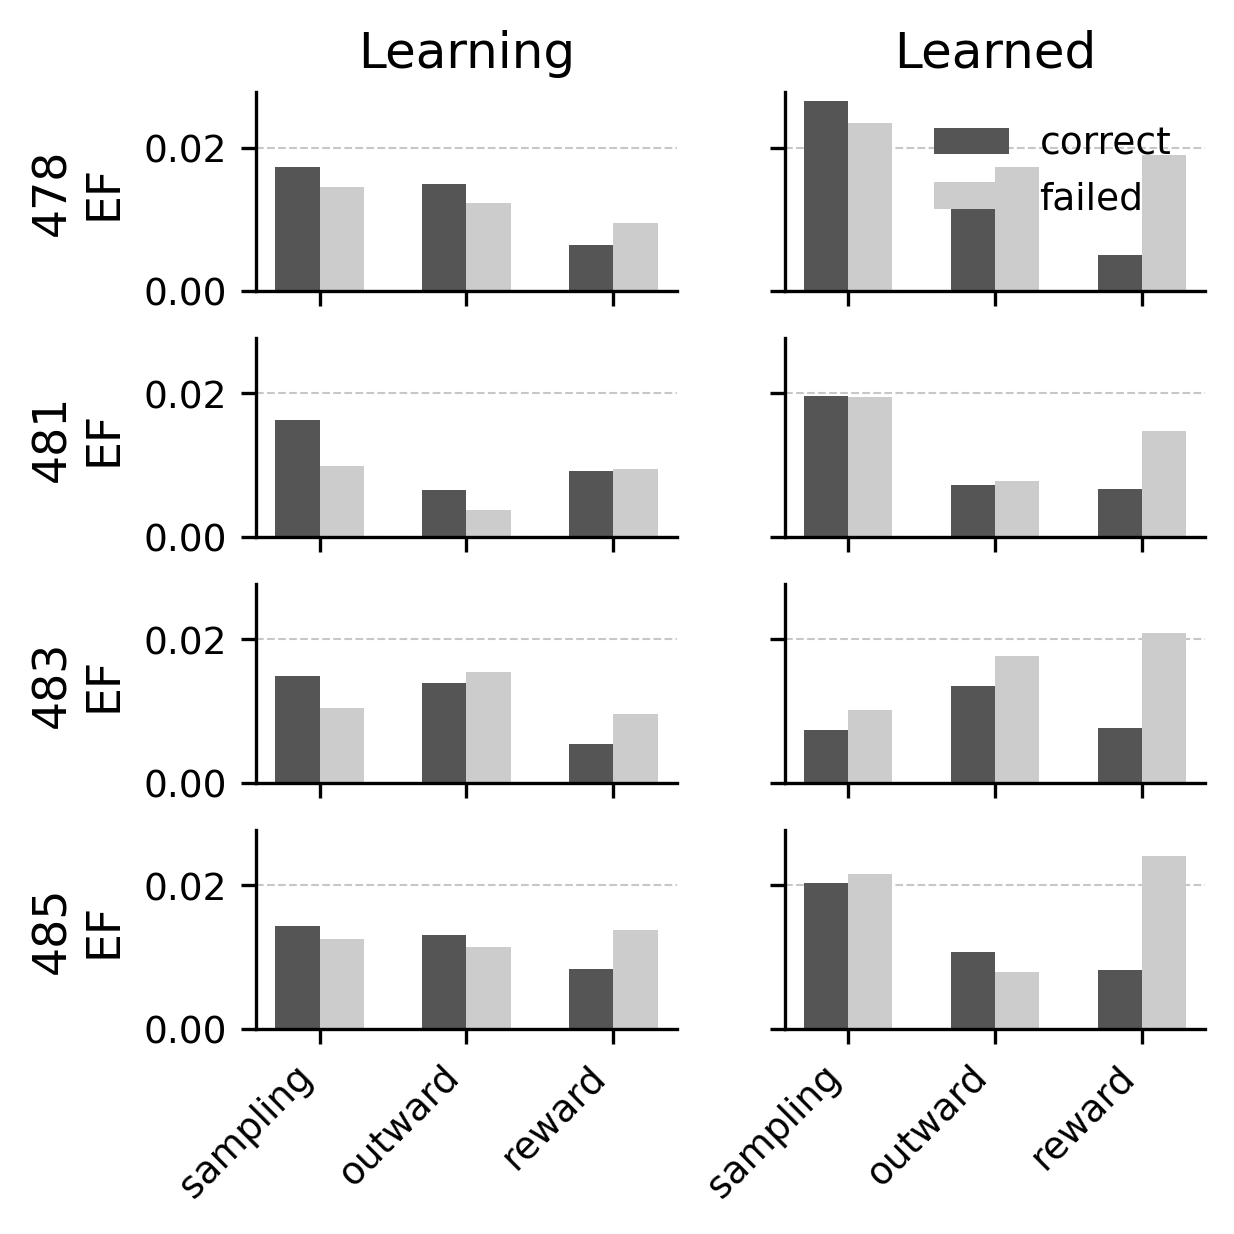

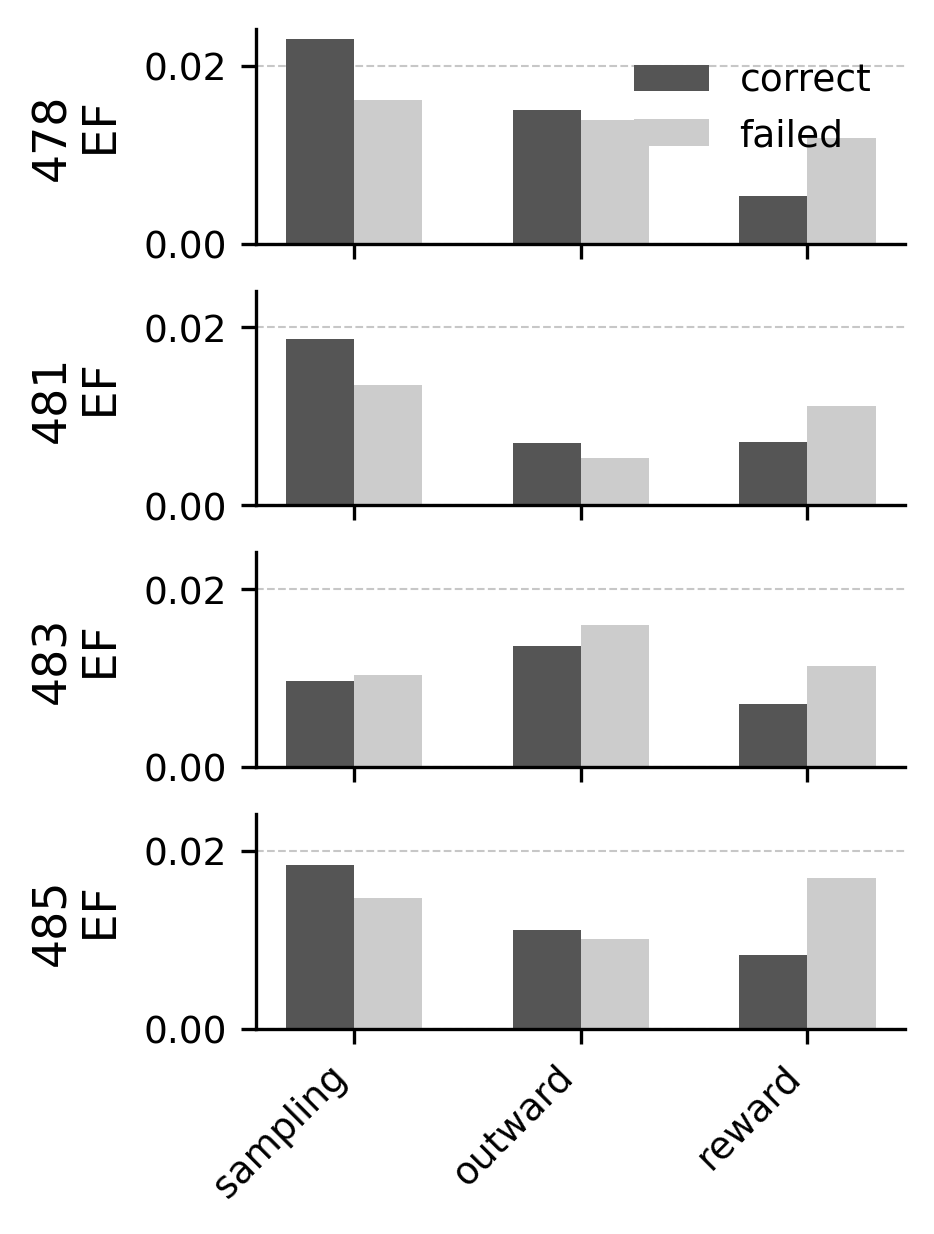

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from os.path import join

# ─────── USER PARAMETERS ─────────────────────────────────────────────────────
#data_file       = 'all_animals_cov_data_with_merged.pkl'
animals         = ['478','481','483','485']
# Exclude 'inward'
base_conditions = ['sampling','outward','reward']
# Grey palette for bars
colors = {
    'correct': '#555555',   # dark grey
    'failed':  '#cccccc'    # light grey
}
# ──────────────────────────────────────────────────────────────────────────────

# # load data
# with open(join(savefolder, data_file), 'rb') as f:
#     all_animals_data = pickle.load(f)

# Common styling for publication
plt.rcParams.update({
    'font.size':       10,
    'axes.labelsize':  11,
    'axes.titlesize':  12,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'legend.fontsize': 9,
    'figure.dpi':      300,
    'axes.linewidth':  0.8,
})

# ──────────────── Figure 1: Individual animals (per phase) ─────────────────
# ... [unchanged from before] ...

# ──────────────── Figure 1: Individual animals ───────────────────────────────
n_anim = len(animals)
fig1, axes1 = plt.subplots(n_anim, 2,
    figsize=(4, 1*n_anim),
    sharex=True, sharey=True,
    constrained_layout=True
)

for i, animal in enumerate(animals):
    for j, phase in enumerate(['learning','learned']):
        ax = axes1[i, j]
        fracs_corr = []
        fracs_fail = []
        for base in base_conditions:
            # single merged event_fraction per base
            fracs_corr.append(all_animals_data[animal][base][phase]['correct']['event_fraction'])
            fracs_fail.append(all_animals_data[animal][base][phase]['failed']['event_fraction'])
        x = np.arange(len(base_conditions))
        w = 0.3

        ax.bar(x - w/2, fracs_corr, w, label='correct',
               color=colors['correct'], edgecolor='none')
        ax.bar(x + w/2, fracs_fail,  w, label='failed',
               color=colors['failed'],  edgecolor='none')

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.yaxis.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
        ax.set_axisbelow(True)

        if i == 0:
            ax.set_title(phase.capitalize(), pad=6)
        if j == 0:
            ax.set_ylabel(f'{animal}\nEF')
        if i == n_anim-1:
            ax.set_xticks(x)
            ax.set_xticklabels(base_conditions, rotation=45, ha='right')
        else:
            ax.set_xticks([])

# Single legend
axes1[0,1].legend(loc='upper right', frameon=False)

fig1.savefig(join(savefolder,'fig1_individuals.svg'),
             dpi=300, format='svg', bbox_inches='tight')


# # ──────────────── Figure 2: All‐animals average ──────────────────────────────
# fig2, axes2 = plt.subplots(1, 2,
#     figsize=(4, 2),
#     sharey=True,
#     constrained_layout=True
# )

# for j, phase in enumerate(['learning','learned']):
#     ax = axes2[j]
#     corr_means = []
#     fail_means = []
#     for base in base_conditions:
#         vals_corr = []
#         vals_fail = []
#         for animal in animals:
#             vals_corr.append(all_animals_data[animal][base][phase]['correct']['event_fraction'])
#             vals_fail.append(all_animals_data[animal][base][phase]['failed']['event_fraction'])
#         corr_means.append(np.nanmean(vals_corr))
#         fail_means.append(np.nanmean(vals_fail))

#     x = np.arange(len(base_conditions))
#     w = 0.3
#     ax.bar(x - w/2, corr_means, w, label='correct',
#            color=colors['correct'], edgecolor='none')
#     ax.bar(x + w/2, fail_means,  w, label='failed',
#            color=colors['failed'],  edgecolor='none')

#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)
#     ax.yaxis.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
#     ax.set_axisbelow(True)

#     ax.set_title(f'{phase.capitalize()}', pad=6)
#     ax.set_xticks(x)
#     ax.set_xticklabels(base_conditions, rotation=45, ha='right')
#     if j == 0:
#         ax.set_ylabel('Mean event fraction')
#     if j == 1:
#         ax.legend(loc='upper right', frameon=False)

# fig2.savefig(join(savefolder,'fig2_grouped.svg'),
#              dpi=300, format='svg', bbox_inches='tight')

# plt.show()

# ──────────────── Figure 3: Individual animals — merged across phases ──────
n_anim = len(animals)
fig3, axes3 = plt.subplots(n_anim, 1,
    figsize=(3, 1*n_anim),
    sharex=True, sharey=True,
    constrained_layout=True
)

for i, animal in enumerate(animals):
    ax = axes3[i]
    fracs_corr = []
    fracs_fail = []
    for base in base_conditions:
        fracs_corr.append(all_animals_data[animal][base]['all']['correct']['event_fraction_merged'])
        fracs_fail.append(all_animals_data[animal][base]['all']['failed']['event_fraction_merged'])
    x = np.arange(len(base_conditions))
    w = 0.3

    ax.bar(x - w/2, fracs_corr, w,
           label='correct', color=colors['correct'], edgecolor='none')
    ax.bar(x + w/2, fracs_fail,  w,
           label='failed',  color=colors['failed'],  edgecolor='none')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.yaxis.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    ax.set_axisbelow(True)

    ax.set_ylabel(f'{animal}\n EF')
    if i == n_anim - 1:
        ax.set_xticks(x)
        ax.set_xticklabels(base_conditions, rotation=45, ha='right')
    else:
        ax.set_xticks([])

# one legend at top
axes3[0].legend(loc='upper right', frameon=False)

fig3.savefig(join(savefolder,'fig3_individuals_merged.svg'),
             dpi=300, format='svg', bbox_inches='tight')


# # ──────────────── Figure 4: All‐animals average — merged across phases ─────
# fig4, ax4 = plt.subplots(1, 1,
#     figsize=(3, 2),
#     constrained_layout=True
# )

# corr_means = []
# fail_means = []
# for base in base_conditions:
#     vals_corr = [all_animals_data[a][base]['all']['correct']['event_fraction_merged']
#                  for a in animals]
#     vals_fail = [all_animals_data[a][base]['all']['failed']['event_fraction_merged']
#                  for a in animals]
#     corr_means.append(np.nanmean(vals_corr))
#     fail_means.append(np.nanmean(vals_fail))

# x = np.arange(len(base_conditions))
# w = 0.3

# ax4.bar(x - w/2, corr_means, w,
#         label='correct', color=colors['correct'], edgecolor='none')
# ax4.bar(x + w/2, fail_means,  w,
#         label='failed',  color=colors['failed'],  edgecolor='none')

# ax4.spines['top'].set_visible(False)
# ax4.spines['right'].set_visible(False)
# ax4.yaxis.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
# ax4.set_axisbelow(True)

# ax4.set_title('Merged EF', pad=6)
# ax4.set_xticks(x)
# ax4.set_xticklabels(base_conditions, rotation=45, ha='right')
# ax4.set_ylabel('Mean merged EF')
# ax4.legend(loc='upper right', frameon=False)

# fig4.savefig(join(savefolder,'fig4_grouped_merged.svg'),
#              dpi=300, format='svg', bbox_inches='tight')

plt.show()


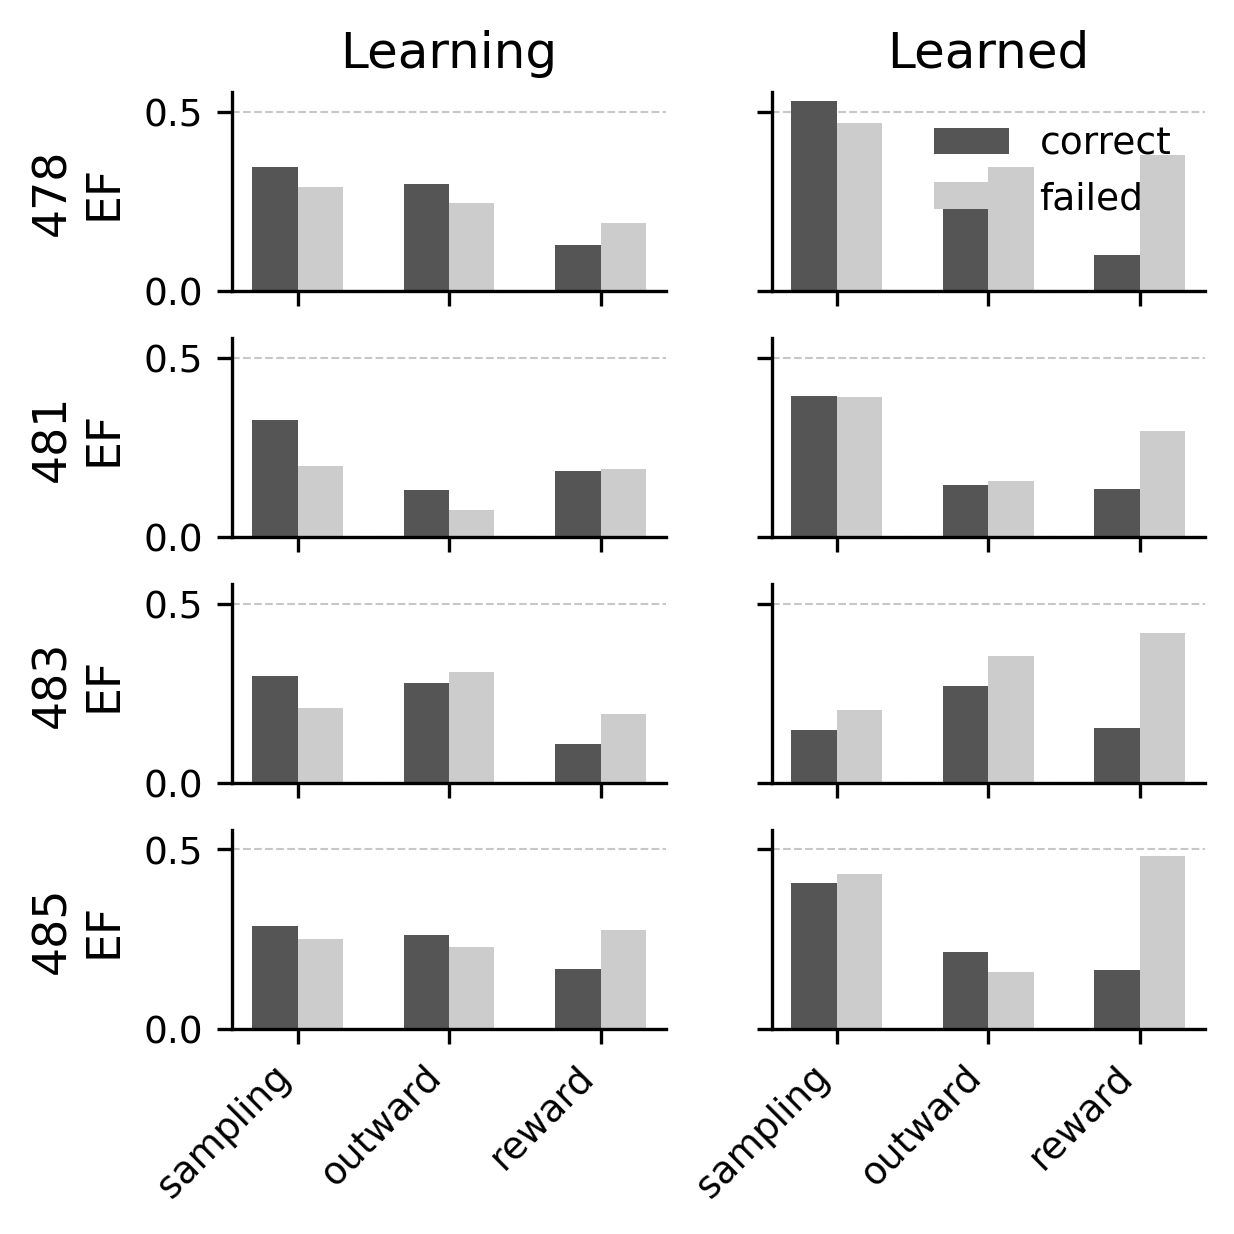

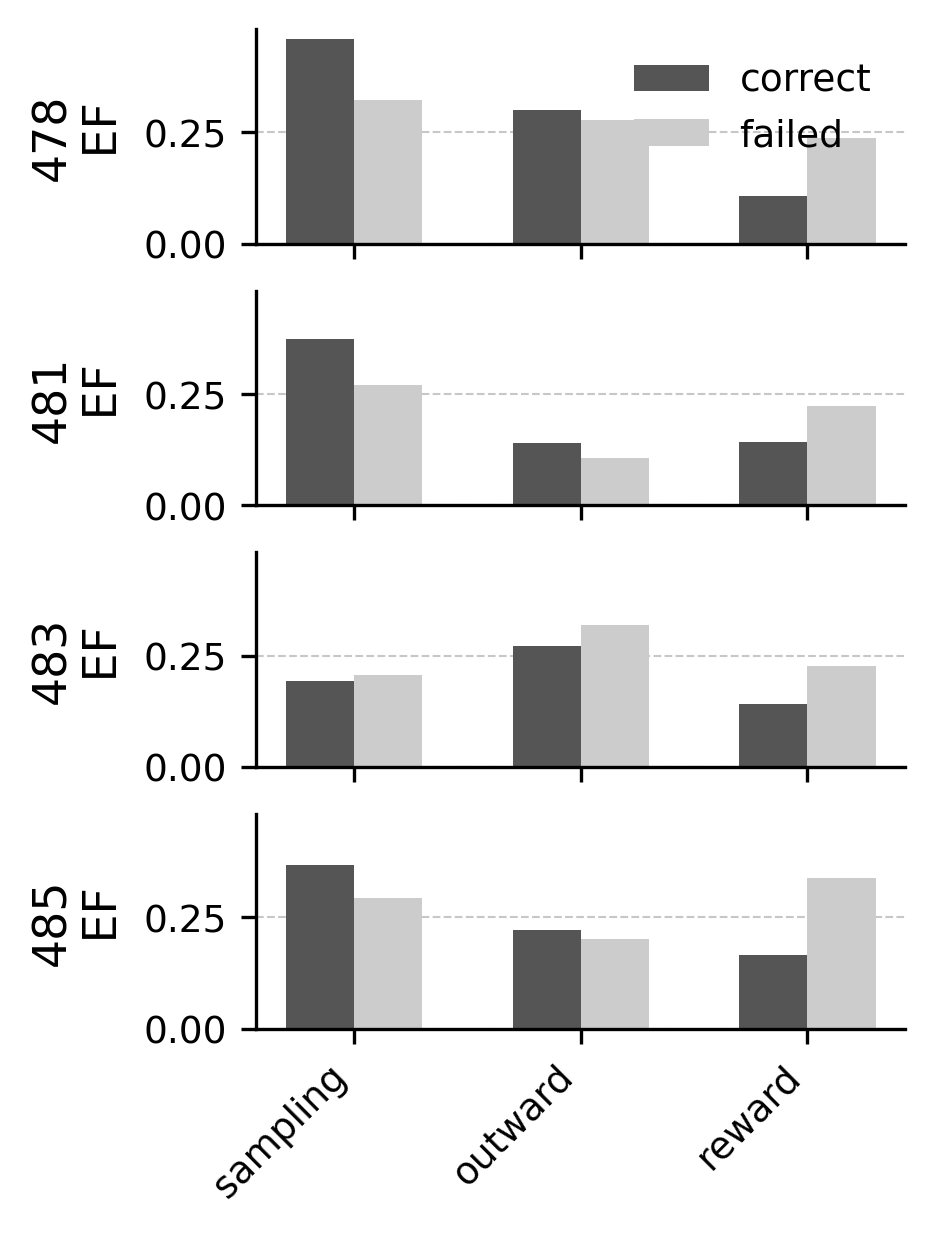

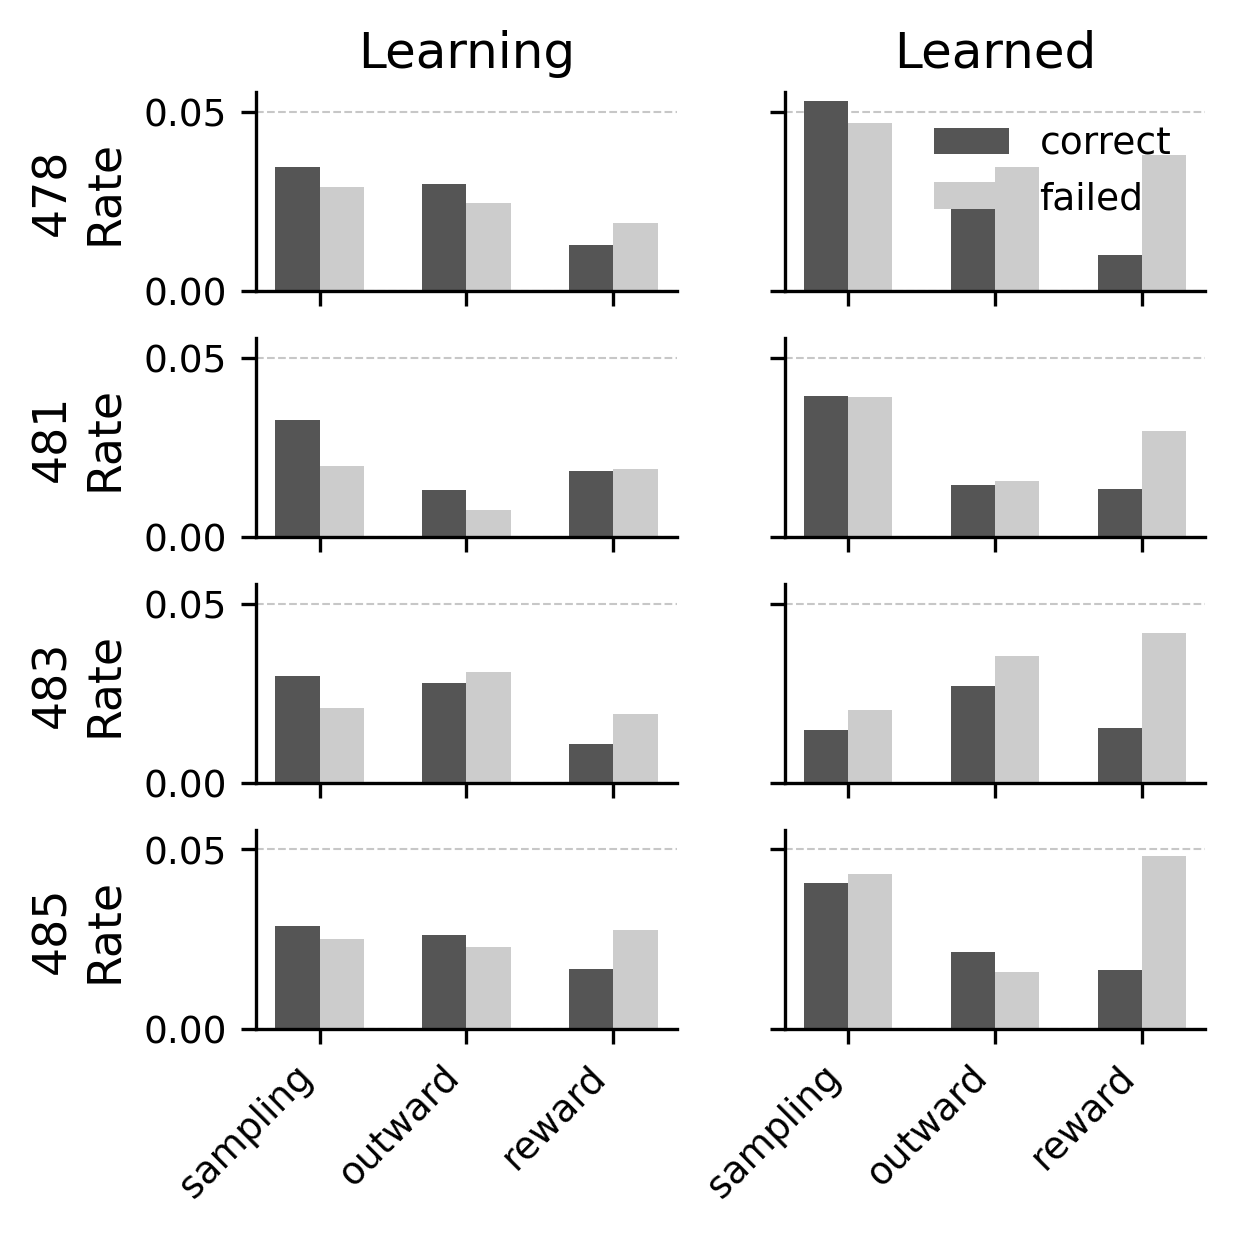

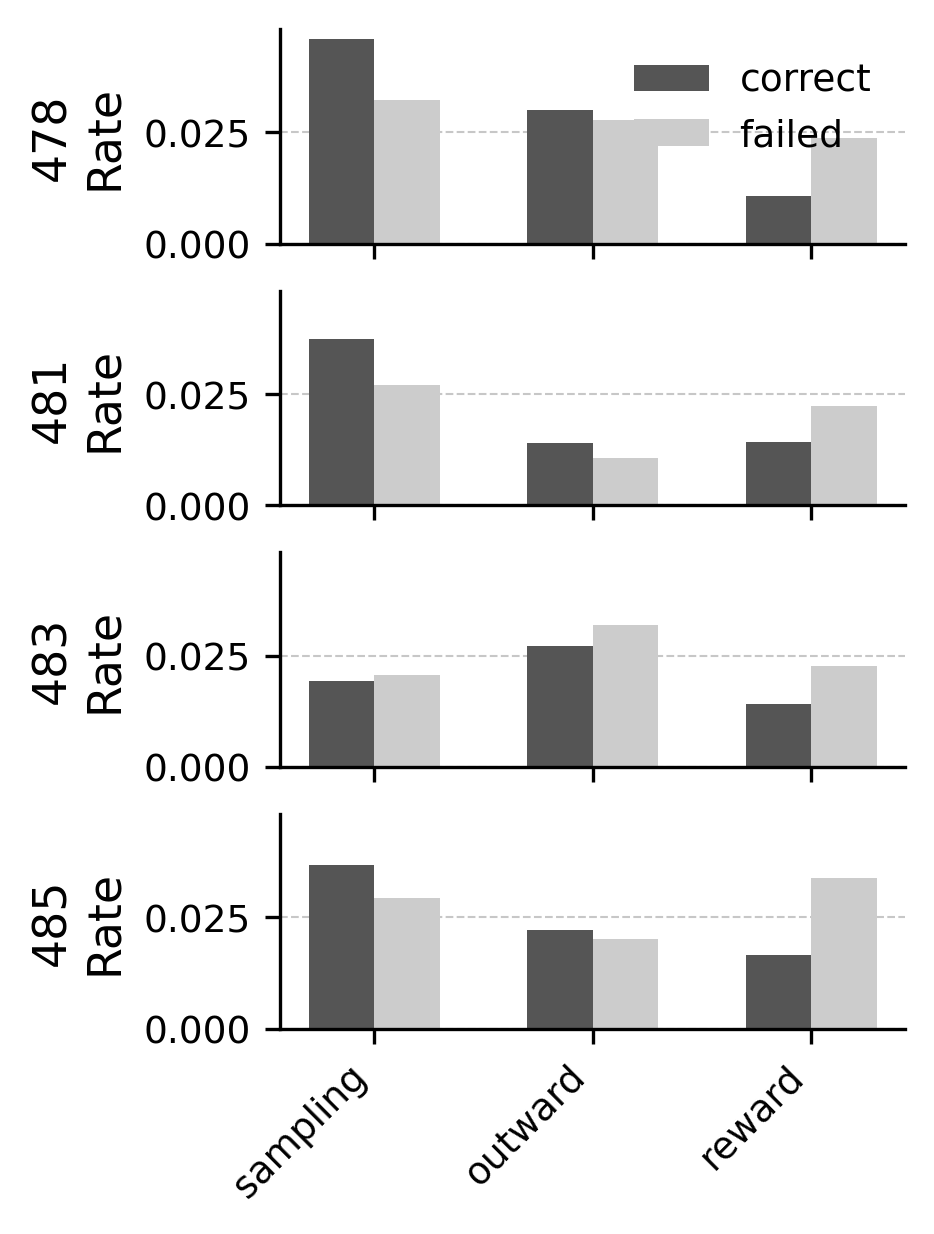

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from os.path import join

# ─────── USER PARAMETERS ─────────────────────────────────────────────────────
#data_file       = 'all_animals_cov_data_with_merged.pkl'
animals         = ['478','481','483','485']
# Exclude 'inward'
base_conditions = ['sampling','outward','reward']
# Grey palette for bars
colors = {
    'correct': '#555555',   # dark grey
    'failed':  '#cccccc'    # light grey
}
# ──────────────────────────────────────────────────────────────────────────────

# # load data
# with open(join(savefolder, data_file), 'rb') as f:
#     all_animals_data = pickle.load(f)

# Common styling for publication
plt.rcParams.update({
    'font.size':       10,
    'axes.labelsize':  11,
    'axes.titlesize':  12,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'legend.fontsize': 9,
    'figure.dpi':      300,
    'axes.linewidth':  0.8,
})

# ──────────────── Figure 1: Individual animals ───────────────────────────────
n_anim = len(animals)
fig1, axes1 = plt.subplots(n_anim, 2,
    figsize=(4, 1*n_anim),
    sharex=True, sharey=True,
    constrained_layout=True
)

for i, animal in enumerate(animals):
    for j, phase in enumerate(['learning','learned']):
        ax = axes1[i, j]
        fracs_corr = []
        fracs_fail = []
        for base in base_conditions:
            fracs_corr.append(all_animals_data[animal][base][phase]['correct']['event_fraction'])
            fracs_fail.append(all_animals_data[animal][base][phase]['failed']['event_fraction'])
        x = np.arange(len(base_conditions))
        w = 0.3

        ax.bar(x - w/2, fracs_corr, w, label='correct',
               color=colors['correct'], edgecolor='none')
        ax.bar(x + w/2, fracs_fail,  w, label='failed',
               color=colors['failed'],  edgecolor='none')

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.yaxis.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
        ax.set_axisbelow(True)

        if i == 0:
            ax.set_title(phase.capitalize(), pad=6)
        if j == 0:
            ax.set_ylabel(f'{animal}\nEF')
        if i == n_anim-1:
            ax.set_xticks(x)
            ax.set_xticklabels(base_conditions, rotation=45, ha='right')
        else:
            ax.set_xticks([])

# Single legend
axes1[0,1].legend(loc='upper right', frameon=False)

fig1.savefig(join(savefolder,'fig1_individuals.svg'),
             dpi=300, format='svg', bbox_inches='tight')

# ──────────────── Figure 3: Individual animals — merged across phases ──────
n_anim = len(animals)
fig3, axes3 = plt.subplots(n_anim, 1,
    figsize=(3, 1*n_anim),
    sharex=True, sharey=True,
    constrained_layout=True
)

for i, animal in enumerate(animals):
    ax = axes3[i]
    fracs_corr = []
    fracs_fail = []
    for base in base_conditions:
        fracs_corr.append(all_animals_data[animal][base]['all']['correct']['event_fraction_merged'])
        fracs_fail.append(all_animals_data[animal][base]['all']['failed']['event_fraction_merged'])
    x = np.arange(len(base_conditions))
    w = 0.3

    ax.bar(x - w/2, fracs_corr, w,
           label='correct', color=colors['correct'], edgecolor='none')
    ax.bar(x + w/2, fracs_fail,  w,
           label='failed',  color=colors['failed'],  edgecolor='none')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.yaxis.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    ax.set_axisbelow(True)

    ax.set_ylabel(f'{animal}\n EF')
    if i == n_anim - 1:
        ax.set_xticks(x)
        ax.set_xticklabels(base_conditions, rotation=45, ha='right')
    else:
        ax.set_xticks([])

# one legend at top
axes3[0].legend(loc='upper right', frameon=False)

fig3.savefig(join(savefolder,'fig3_individuals_merged.svg'),
             dpi=300, format='svg', bbox_inches='tight')

# ──────────────── Figure 5: Individual animals (per phase) — rates ─────────
n_anim = len(animals)
fig5, axes5 = plt.subplots(n_anim, 2,
    figsize=(4, 1*n_anim),
    sharex=True, sharey=True,
    constrained_layout=True
)

for i, animal in enumerate(animals):
    for j, phase in enumerate(['learning','learned']):
        ax = axes5[i, j]
        rates_corr = []
        rates_fail = []
        for base in base_conditions:
            rates_corr.append(all_animals_data[animal][base][phase]['correct']['event_rate'])
            rates_fail.append(all_animals_data[animal][base][phase]['failed']['event_rate'])
        x = np.arange(len(base_conditions))
        w = 0.3

        ax.bar(x - w/2, rates_corr, w, label='correct',
               color=colors['correct'], edgecolor='none')
        ax.bar(x + w/2, rates_fail,  w, label='failed',
               color=colors['failed'],  edgecolor='none')

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.yaxis.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
        ax.set_axisbelow(True)

        if i == 0:
            ax.set_title(phase.capitalize(), pad=6)
        if j == 0:
            ax.set_ylabel(f'{animal}\nRate')
        if i == n_anim-1:
            ax.set_xticks(x)
            ax.set_xticklabels(base_conditions, rotation=45, ha='right')
        else:
            ax.set_xticks([])

# Single legend
axes5[0,1].legend(loc='upper right', frameon=False)

fig5.savefig(join(savefolder,'fig5_individuals_rates.svg'),
             dpi=300, format='svg', bbox_inches='tight')

# ──────────────── Figure 6: Individual animals — merged rates ─────────────
n_anim = len(animals)
fig6, axes6 = plt.subplots(n_anim, 1,
    figsize=(3, 1*n_anim),
    sharex=True, sharey=True,
    constrained_layout=True
)

for i, animal in enumerate(animals):
    ax = axes6[i]
    rates_corr = []
    rates_fail = []
    for base in base_conditions:
        rates_corr.append(all_animals_data[animal][base]['all']['correct']['event_rate_merged'])
        rates_fail.append(all_animals_data[animal][base]['all']['failed']['event_rate_merged'])
    x = np.arange(len(base_conditions))
    w = 0.3

    ax.bar(x - w/2, rates_corr, w,
           label='correct', color=colors['correct'], edgecolor='none')
    ax.bar(x + w/2, rates_fail,  w,
           label='failed',  color=colors['failed'],  edgecolor='none')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.yaxis.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    ax.set_axisbelow(True)

    ax.set_ylabel(f'{animal}\nRate')
    if i == n_anim - 1:
        ax.set_xticks(x)
        ax.set_xticklabels(base_conditions, rotation=45, ha='right')
    else:
        ax.set_xticks([])

# one legend at top
axes6[0].legend(loc='upper right', frameon=False)

fig6.savefig(join(savefolder,'fig6_individuals_merged_rates.svg'),
             dpi=300, format='svg', bbox_inches='tight')

plt.show()


In [17]:
corr_stds

[0.09645953209569505, 0.06093160050084644, 0.02062113486287084]

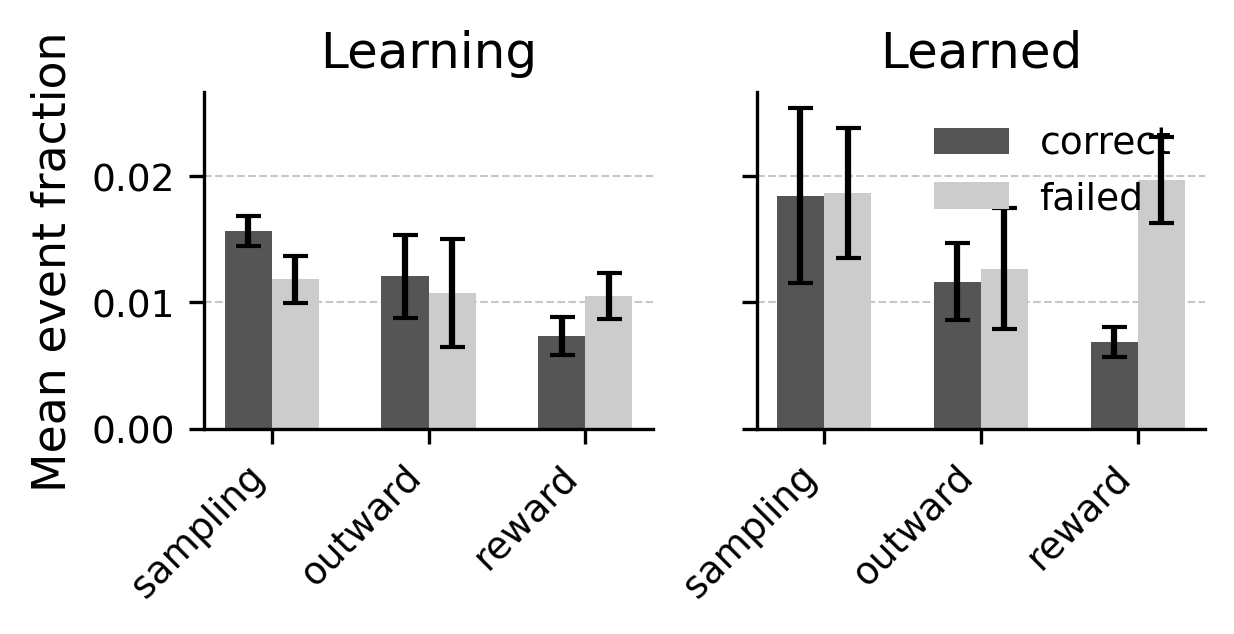

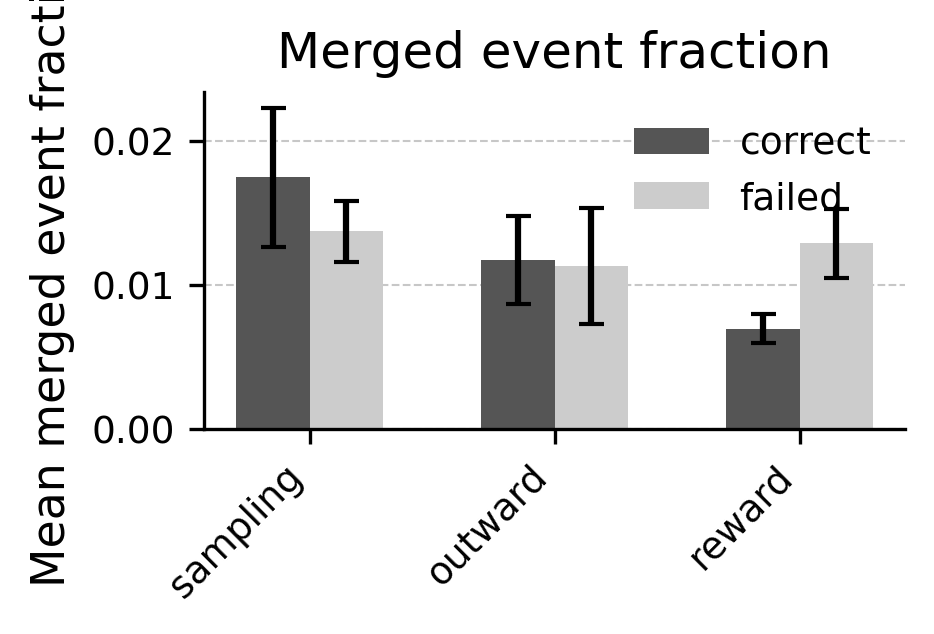

In [42]:
# ──────────────── Figure 2: All‐animals average ──────────────────────────────
fig2, axes2 = plt.subplots(1, 2,
    figsize=(4, 2),
    sharey=True,
    constrained_layout=True
)

for j, phase in enumerate(['learning','learned']):
    ax = axes2[j]
    corr_means = []
    corr_stds  = []      # ← collect stds
    fail_means = []
    fail_stds  = []      # ← collect stds
    for base in base_conditions:
        vals_corr = [all_animals_data[a][base][phase]['correct']['event_fraction']
                     for a in animals]
        vals_fail = [all_animals_data[a][base][phase]['failed']['event_fraction']
                     for a in animals]
        corr_means.append(np.nanmean(vals_corr))
        corr_stds .append(np.nanstd( vals_corr))    # ← compute std
        fail_means.append(np.nanmean(vals_fail))
        fail_stds .append(np.nanstd( vals_fail))    # ← compute std

    x = np.arange(len(base_conditions))
    w = 0.3
    ax.bar(x - w/2, corr_means, w,
           yerr=corr_stds, capsize=3,               # ← add yerr
           label='correct',
           color=colors['correct'], edgecolor='none')
    ax.bar(x + w/2, fail_means,  w,
           yerr=fail_stds,  capsize=3,               # ← add yerr
           label='failed',
           color=colors['failed'],  edgecolor='none')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.yaxis.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    ax.set_axisbelow(True)

    ax.set_title(f'{phase.capitalize()}', pad=6)
    ax.set_xticks(x)
    ax.set_xticklabels(base_conditions, rotation=45, ha='right')
    if j == 0:
        ax.set_ylabel('Mean event fraction')
    if j == 1:
        ax.legend(loc='upper right', frameon=False)

fig2.savefig(join(savefolder,'fig2_grouped.svg'),
             dpi=300, format='svg', bbox_inches='tight')


# ──────────────── Figure 4: All‐animals average — merged across phases ─────
fig4, ax4 = plt.subplots(1, 1,
    figsize=(3, 2),
    constrained_layout=True
)

corr_means = []
corr_stds  = []          # ← collect stds
fail_means = []
fail_stds  = []          # ← collect stds
for base in base_conditions:
    vals_corr = [all_animals_data[a][base]['all']['correct']['event_fraction_merged']
                 for a in animals]
    vals_fail = [all_animals_data[a][base]['all']['failed']['event_fraction_merged']
                 for a in animals]
    corr_means.append(np.nanmean(vals_corr))
    corr_stds .append(np.nanstd( vals_corr))       # ← compute std
    fail_means.append(np.nanmean(vals_fail))
    fail_stds .append(np.nanstd( vals_fail))       # ← compute std

x = np.arange(len(base_conditions))
w = 0.3

ax4.bar(x - w/2, corr_means, w,
        yerr=corr_stds, capsize=3,               # ← add yerr
        label='correct', color=colors['correct'], edgecolor='none')
ax4.bar(x + w/2, fail_means,  w,
        yerr=fail_stds,  capsize=3,               # ← add yerr
        label='failed',  color=colors['failed'],  edgecolor='none')

ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)
ax4.yaxis.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
ax4.set_axisbelow(True)

ax4.set_title('Merged event fraction', pad=6)
ax4.set_xticks(x)
ax4.set_xticklabels(base_conditions, rotation=45, ha='right')
ax4.set_ylabel('Mean merged event fraction')
ax4.legend(loc='upper right', frameon=False)

fig4.savefig(join(savefolder,'fig4_grouped_merged.svg'),
             dpi=300, format='svg', bbox_inches='tight')


In [ ]:
sdfsdf

KeyError: 'sampling_L'

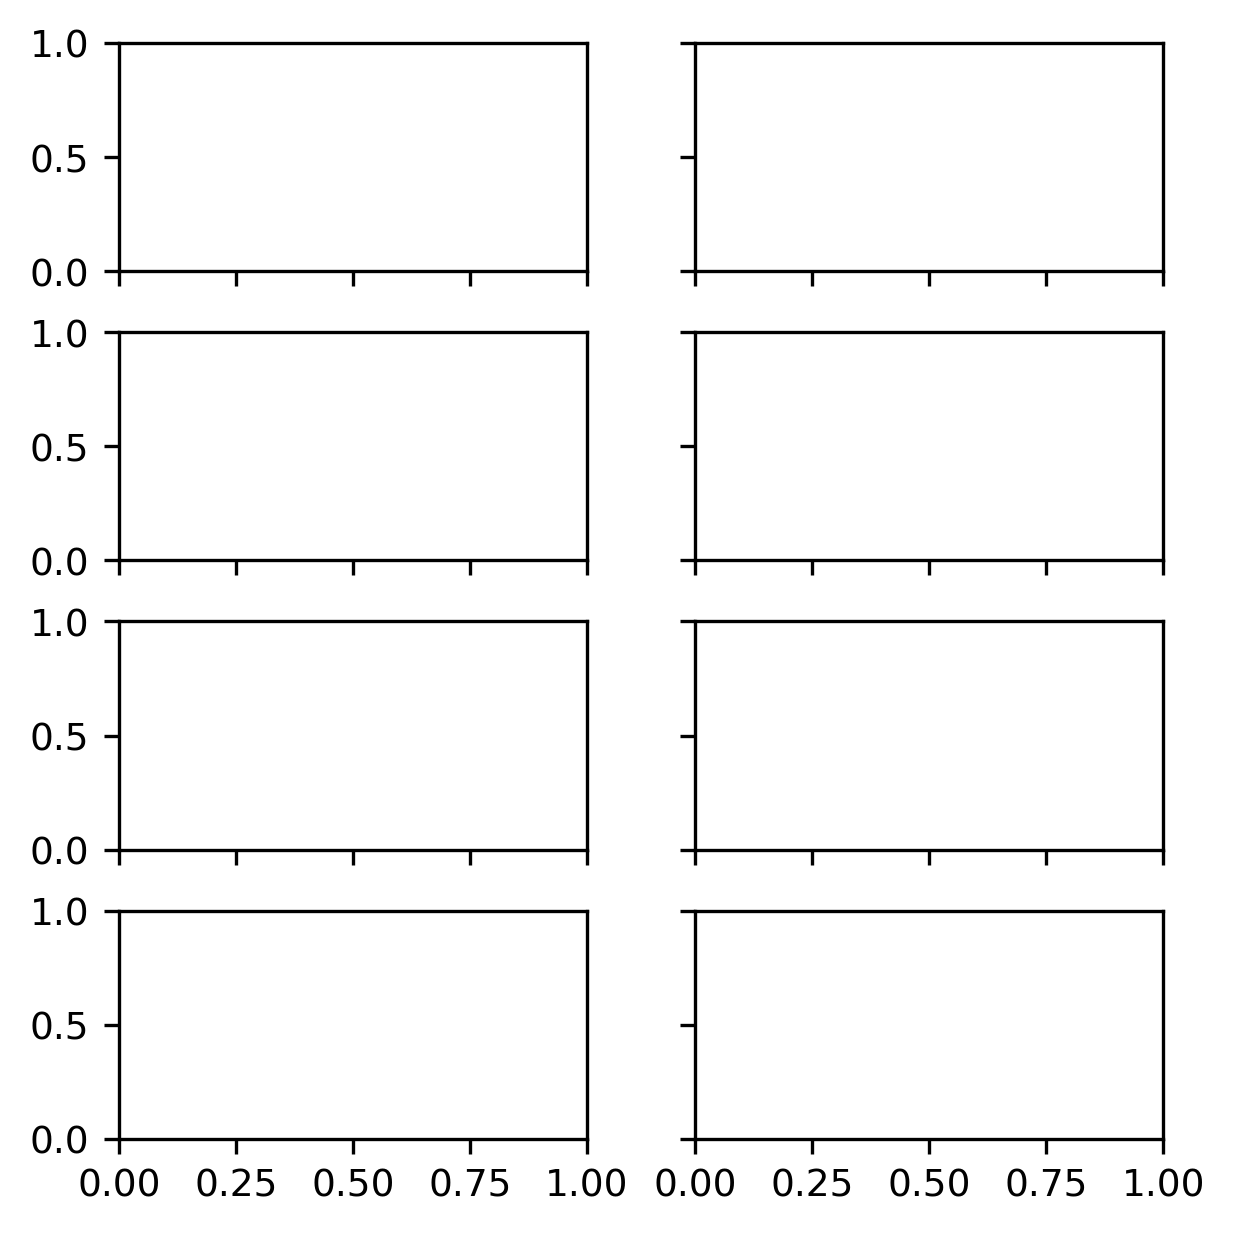

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from os.path import join

# ─────── USER PARAMETERS ─────────────────────────────────────────────────────
#savefolder      = '/path/to/your/savefolder'
phase_file      = 'all_animals_phase_data.pkl'
animals         = ['478','481','483','485']
# Exclude 'inward'
base_conditions = ['sampling','outward','reward']
# Grey palette for bars
colors = {
    'correct': '#555555',   # dark grey
    'failed':  '#cccccc'    # light grey
}
# ──────────────────────────────────────────────────────────────────────────────

# load data
# with open(join(savefolder, phase_file), 'rb') as f:
#     phase_data = pickle.load(f)

# Common styling for publication
plt.rcParams.update({
    'font.size':       10,
    'axes.labelsize':  11,
    'axes.titlesize':  12,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'legend.fontsize': 9,
    'figure.dpi':      300,
    'axes.linewidth':  0.8,
})

# ──────────────── Figure 1: Individual animals ───────────────────────────────
n_anim = len(animals)
fig1, axes1 = plt.subplots(n_anim, 2,
    figsize=(4, 1*n_anim),
    sharex=True, sharey=True,
    constrained_layout=True
)

for i, animal in enumerate(animals):
    for j, phase in enumerate(['learning','learned']):
        ax = axes1[i, j]
        fracs_corr = []
        fracs_fail = []
        for base in base_conditions:
            fL = all_animals_data[animal][f'{base}_L'][phase]['correct']['event_fraction']
            fR = all_animals_data[animal][f'{base}_R'][phase]['correct']['event_fraction']
            fracs_corr.append(np.nanmean([fL, fR]))
            fL = all_animals_data[animal][f'{base}_L'][phase]['failed']['event_fraction']
            fR = all_animals_data[animal][f'{base}_R'][phase]['failed']['event_fraction']
            fracs_fail.append(np.nanmean([fL, fR]))
        x = np.arange(len(base_conditions))
        w = 0.3

        ax.bar(x - w/2, fracs_corr, w, label='correct',
               color=colors['correct'], edgecolor='none')
        ax.bar(x + w/2, fracs_fail,  w, label='failed',
               color=colors['failed'],  edgecolor='none')

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.yaxis.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
        ax.set_axisbelow(True)

        if i == 0:
            ax.set_title(phase.capitalize(), pad=6)
        if j == 0:
            ax.set_ylabel(f'Animal {animal}\nEvent fraction')
        if i == n_anim-1:
            ax.set_xticks(x)
            ax.set_xticklabels(base_conditions, rotation=45, ha='right')
        else:
            ax.set_xticks([])

# Single legend
axes1[0,1].legend(loc='upper right', frameon=False)

fig1.savefig(join(savefolder,'fig1_individuals.svg'),
             dpi=300, format='svg', bbox_inches='tight')


# ──────────────── Figure 2: All‐animals average ──────────────────────────────
fig2, axes2 = plt.subplots(1, 2,
    figsize=(4, 2),
    sharey=True,
    constrained_layout=True
)

for j, phase in enumerate(['learning','learned']):
    ax = axes2[j]
    corr_means = []
    fail_means = []
    for base in base_conditions:
        vals_corr = []
        vals_fail = []
        for animal in animals:
            fL = all_animals_data[animal][f'{base}_L'][phase]['correct']['event_fraction']
            fR = all_animals_data[animal][f'{base}_R'][phase]['correct']['event_fraction']
            vals_corr.append(np.nanmean([fL, fR]))
            fL = all_animals_data[animal][f'{base}_L'][phase]['failed']['event_fraction']
            fR = all_animals_data[animal][f'{base}_R'][phase]['failed']['event_fraction']
            vals_fail.append(np.nanmean([fL, fR]))
        corr_means.append(np.nanmean(vals_corr))
        fail_means.append(np.nanmean(vals_fail))

    x = np.arange(len(base_conditions))
    w = 0.3
    ax.bar(x - w/2, corr_means, w, label='correct',
           color=colors['correct'], edgecolor='none')
    ax.bar(x + w/2, fail_means,  w, label='failed',
           color=colors['failed'],  edgecolor='none')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.yaxis.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    ax.set_axisbelow(True)

    ax.set_title(f'All animals — {phase.capitalize()}', pad=6)
    ax.set_xticks(x)
    ax.set_xticklabels(base_conditions, rotation=45, ha='right')
    if j == 0:
        ax.set_ylabel('Mean event fraction')
    if j == 1:
        ax.legend(loc='upper right', frameon=False)

# fig2.savefig(join(savefolder,'fig2_grouped.svg'),
#              dpi=300, format='svg', bbox_inches='tight')


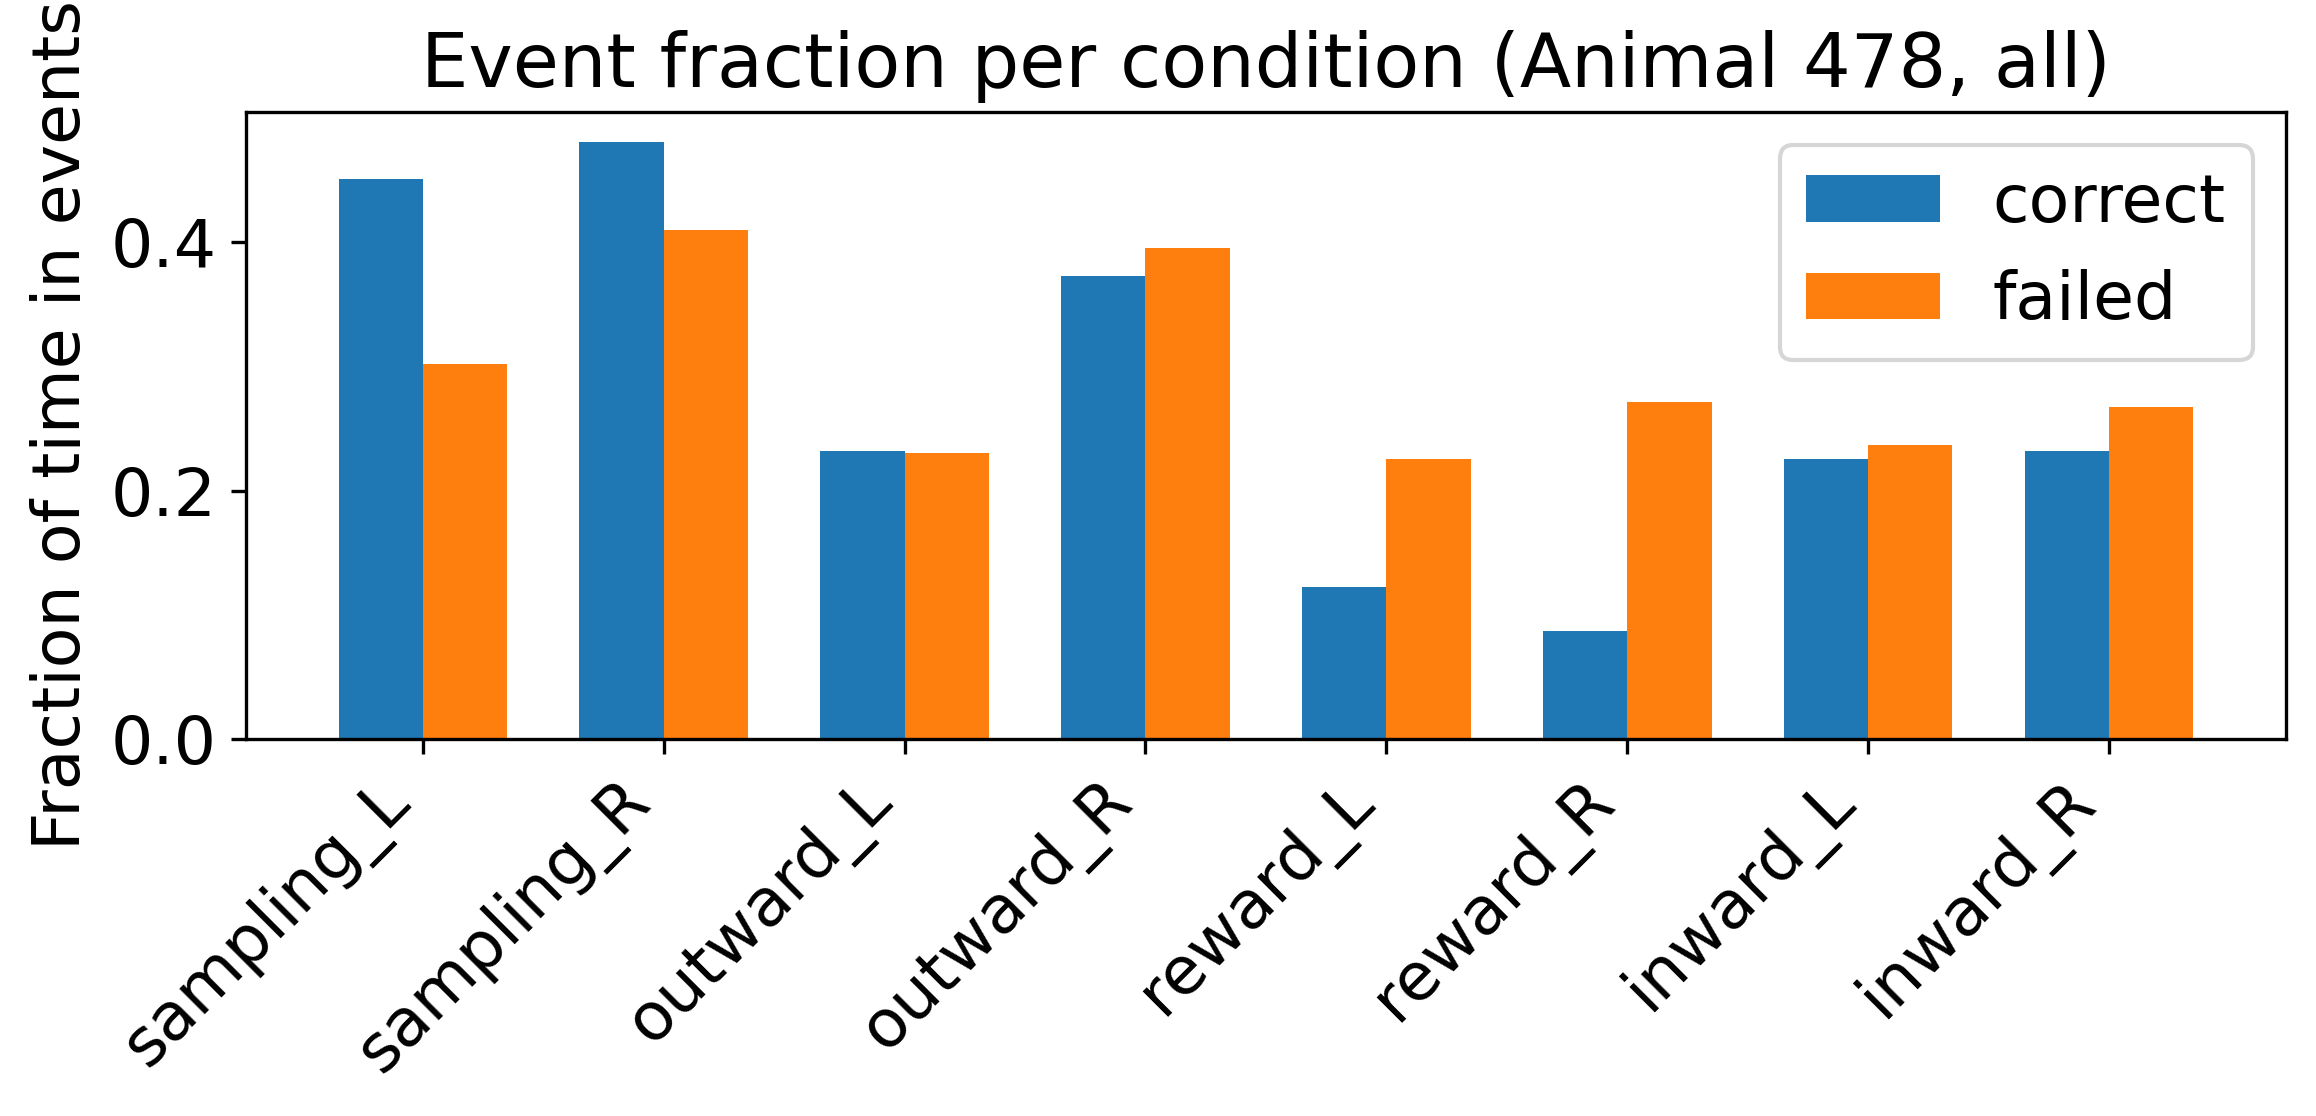

In [ ]:
import matplotlib.pyplot as plt

animal_data = all_animals_data['478']    # replace with your dict
phase_name  = 'all'

conds   = list(cond_names.keys())
fractions_correct = [animal_data[c][phase_name]['correct']['event_fraction']
                     for c in conds]
fractions_failed  = [animal_data[c][phase_name]['failed']['event_fraction']
                     for c in conds]

x = range(len(conds))
width = 0.35

fig, ax = plt.subplots(figsize=(8,4))
ax.bar([xi - width/2 for xi in x], fractions_correct, width, label='correct')
ax.bar([xi + width/2 for xi in x], fractions_failed,  width, label='failed')

ax.set_xticks(x)
ax.set_xticklabels(conds, rotation=45, ha='right')
ax.set_ylabel('Fraction of time in events')
ax.set_title(f'Event fraction per condition (Animal 478, {phase_name})')
ax.legend()

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pickle
import copy
from os.path import join

fs = 20                    # sampling rate (Hz)
bin_ms = 250               # bin size (ms)
bin_samples = int(fs * bin_ms / 1000)  # → 5 samples/bin

# your mapping of condition‑names → their index in `apply_masks_test`
cond_names = {
    'sampling_L': 0,
    'sampling_R': 1,
    'outward_L': 2,
    'outward_R': 3,
    'reward_L': 4,
    'reward_R': 5,
    'inward_L': 6,
    'inward_R': 7
}

# trial types
trial_types = {
    1:      'correct',
    0:      'failed'
}

# top-level containers for **all** animals
all_animals_phase_data   = {}
all_animals_session_data = {}

for fol in ['478','481','483','485']:
    # ----------------------------
    # existing phase‐based analysis
    # ----------------------------
    binned_calcum_traced = {}

    # load your session info & masks just once per folder
    filename        = fol + 'Sesseion_info_All AllNo_chunk_0.5s_transients'
    data_all_tasks  = np.load(join(savefolder, filename), allow_pickle=True)
    sess_info       = data_all_tasks['sess_info']

    filename_mask   = fol + 'Mask_with_correct_cells'
    Masks_          = np.load(join(savefolder, filename_mask), allow_pickle=True)
    Masks           = Masks_[0]
    session_mask    = Masks_[1]

    # compute your speed mask
    smooth_speed = mot.smooth_signal(sess_info['speed'], 13)
    Masks['speed_seq'] = np.asarray(smooth_speed)[sess_info['id_peaks']] > 0
    Masks['speed']     = smooth_speed > 0

    sessin_numbers = np.arange(len(session_mask))

    # (phase‐based loops omitted for brevity; assume your existing code populates
    #  binned_calcum_traced exactly as before)
    # ...
    all_animals_phase_data[fol] = copy.deepcopy(binned_calcum_traced)


    # -----------------------------------
    # NEW: session‐based analysis variable
    # -----------------------------------
    session_calcum_traced = {}

    for sess in sessin_numbers:
        session_calcum_traced[sess] = {}
        for cond_name, cond_idx in cond_names.items():
            session_calcum_traced[sess][cond_name] = {}
            for trial_type, type_name in trial_types.items():
                # pull data for this single session only
                run_data = mot.apply_masks_test(
                    sess_info, Masks,
                    [cond_idx],
                    cond_names, 
                    [sess],        # <-- only this session
                    None,          # all trials
                    session_mask,
                    trial_type,
                    None           # no phase filter
                )

                # raw traces
                raw = run_data['trace_cells']
                n_cells, n_tpts = raw.shape

                # bin into 250 ms chunks
                n_bins       = n_tpts // bin_samples
                trunc_length = n_bins * bin_samples
                truncated    = raw[:, :trunc_length]
                binned       = truncated.reshape(n_cells, n_bins, bin_samples).mean(axis=2)

                # covariance
                cov_mat = np.cov(binned)

                # store in the session dict
                session_calcum_traced[sess][cond_name][type_name] = {
                    'binned':  binned,
                    'cov_mat': cov_mat,
                    'seqs':    run_data['seqs']
                }

    all_animals_session_data[fol] = copy.deepcopy(session_calcum_traced)


# save phase‐based file
# phase_save = join(savefolder, 'all_animals_phase_data.pkl')
# with open(phase_save, 'wb') as f:
#     pickle.dump(all_animals_phase_data, f)
# print(f"Saved phase data → {phase_save}")

# save session‐based file
session_save = join(savefolder, 'all_animals_session_cov_data.pkl')
with open(session_save, 'wb') as f:
    pickle.dump(all_animals_session_data, f)
print(f"Saved session data → {session_save}")










# Pick an example:
animal     = '478'        # one of ['478','481','483','485']
session_ix = 0            # session index
condition  = 'outward_R'  # one of cond_names keys
trial      = 'correct'    # 'correct' or 'failed'
# 2) pull out the example covariance matrix
cov_mat = all_animals_session_data[animal][session_ix][condition][trial]['cov_mat']

# 3) plot it as a heatmap
plt.figure(figsize=(6,6))
plt.imshow(cov_mat, aspect='auto', origin='lower')
plt.title(f'Covariance — Animal {animal}, Session {session_ix}, {condition}, {trial}')
plt.xlabel('Cell index')
plt.ylabel('Cell index')
cbar = plt.colorbar()
cbar.set_label('Covariance')
plt.tight_layout()
plt.show()

C:\Users\hamed\AppData\Local\Temp\ipykernel_4872\935463756.py:94: RuntimeWarning: Degrees of freedom <= 0 for slice
  cov_mat = np.cov(binned)


Saved session data → C:\Users\hamed\Desktop\Hamed\Github\TP7\results_new\all_animals_session_cov_data.pkl


In [ ]:
all_animals_session_data[animal][session_ix][condition][trial]['seqs']

array([array([13, 39, 83, 24, 31, 82, 80, 61, 62, 47, 59], dtype=int64),
       array([47, 57,  7, 31, 17, 34, 69, 11, 44, 19, 24], dtype=int64),
       array([56, 51, 41, 60, 55,  6, 73, 80, 23, 86, 45], dtype=int64),
       array([55, 73,  6, 45, 23, 72, 75, 80, 62, 61,  0, 47, 28], dtype=int64),
       array([23,  0, 45, 62, 47, 61, 52, 80, 28, 22, 57, 54, 36], dtype=int64),
       array([31, 57, 47, 76, 19, 34, 44, 11, 69, 14], dtype=int64),
       array([59, 80, 43, 31, 16, 68, 54, 22, 36, 57], dtype=int64),
       array([54, 34, 19, 44, 11, 17, 84, 69, 35], dtype=int64),
       array([28, 61, 16, 47, 83, 54,  4, 39, 64, 52, 79, 15, 22], dtype=int64),
       array([13, 54, 80, 18,  1, 46, 59, 16, 22, 52, 57], dtype=int64),
       array([22, 33, 41,  4, 71, 81, 40, 48], dtype=int64),
       array([43, 54, 38, 77, 68, 29, 51, 55,  4, 64], dtype=int64),
       array([55, 64, 51, 29, 68, 77, 38, 46,  1], dtype=int64)],
      dtype=object)

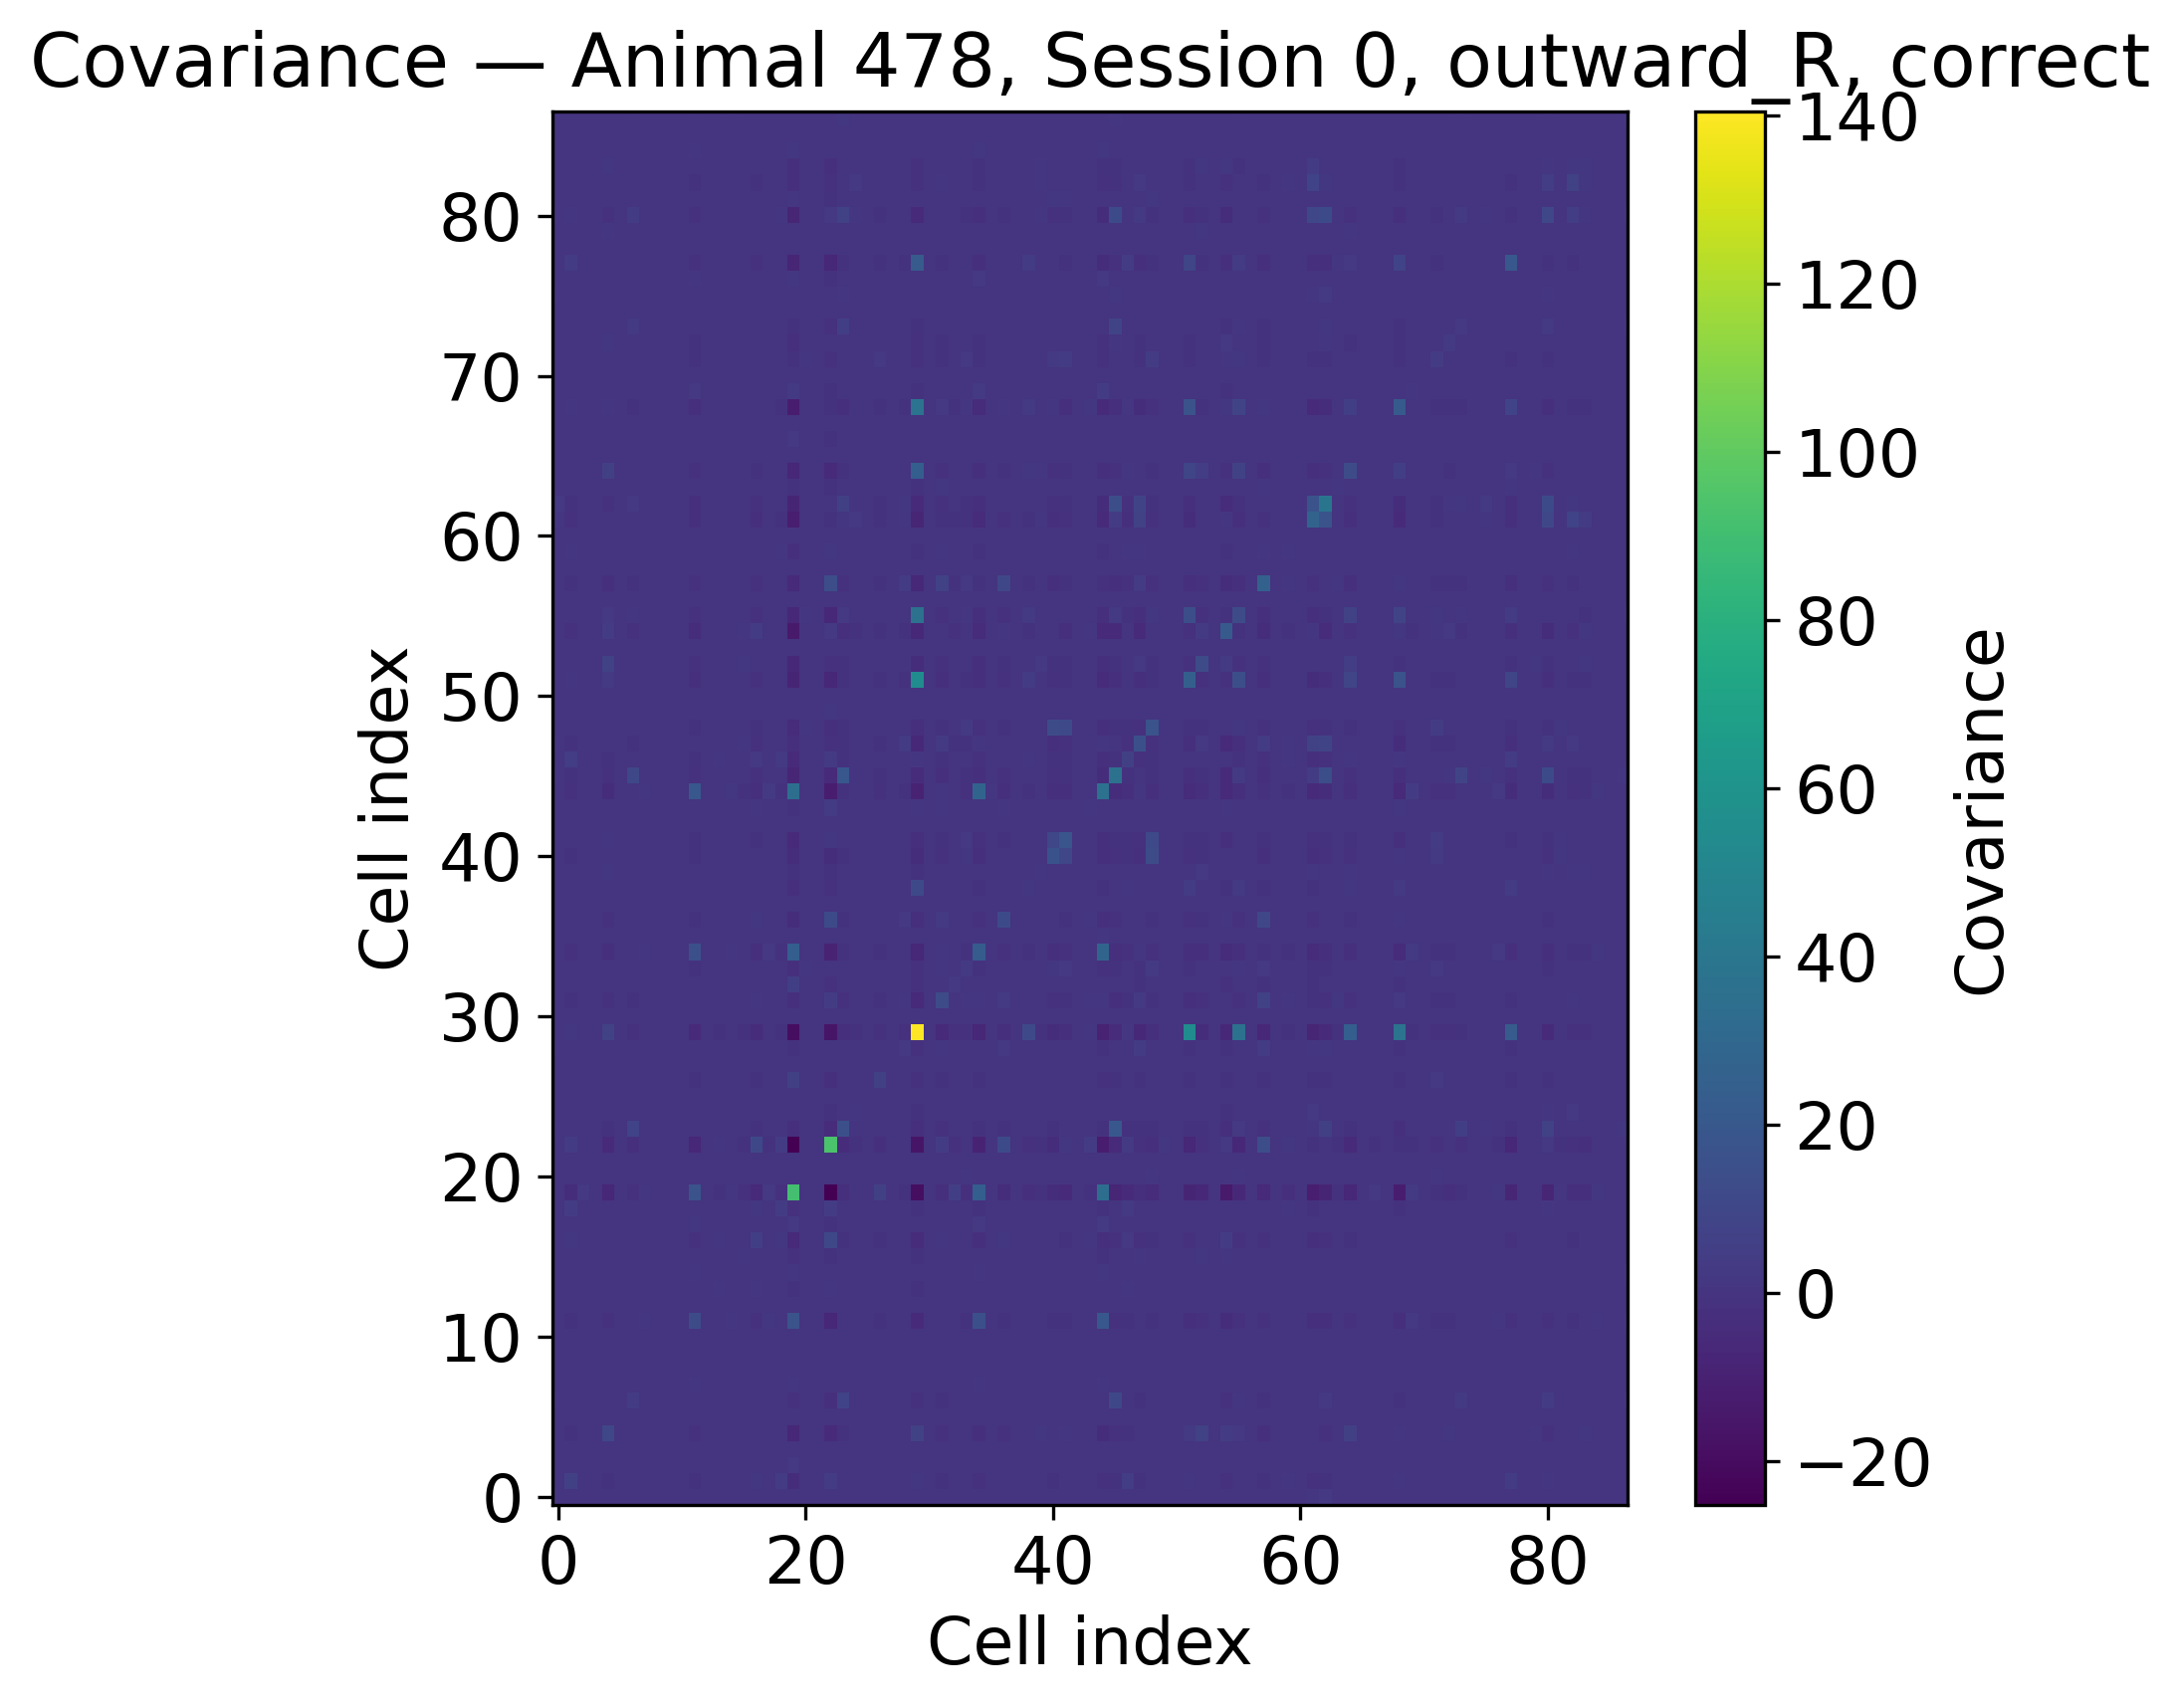

In [ ]:
# Pick an example:
animal     = '478'        # one of ['478','481','483','485']
session_ix = 0            # session index
condition  = 'outward_R'  # one of cond_names keys
trial      = 'correct'    # 'correct' or 'failed'
# 2) pull out the example covariance matrix
cov_mat = all_animals_session_data[animal][session_ix][condition][trial]['cov_mat']

# 3) plot it as a heatmap
plt.figure(figsize=(6,6))
plt.imshow(cov_mat, aspect='auto', origin='lower')
plt.title(f'Covariance — Animal {animal}, Session {session_ix}, {condition}, {trial}')
plt.xlabel('Cell index')
plt.ylabel('Cell index')
cbar = plt.colorbar()
cbar.set_label('Covariance')
plt.tight_layout()
plt.show()

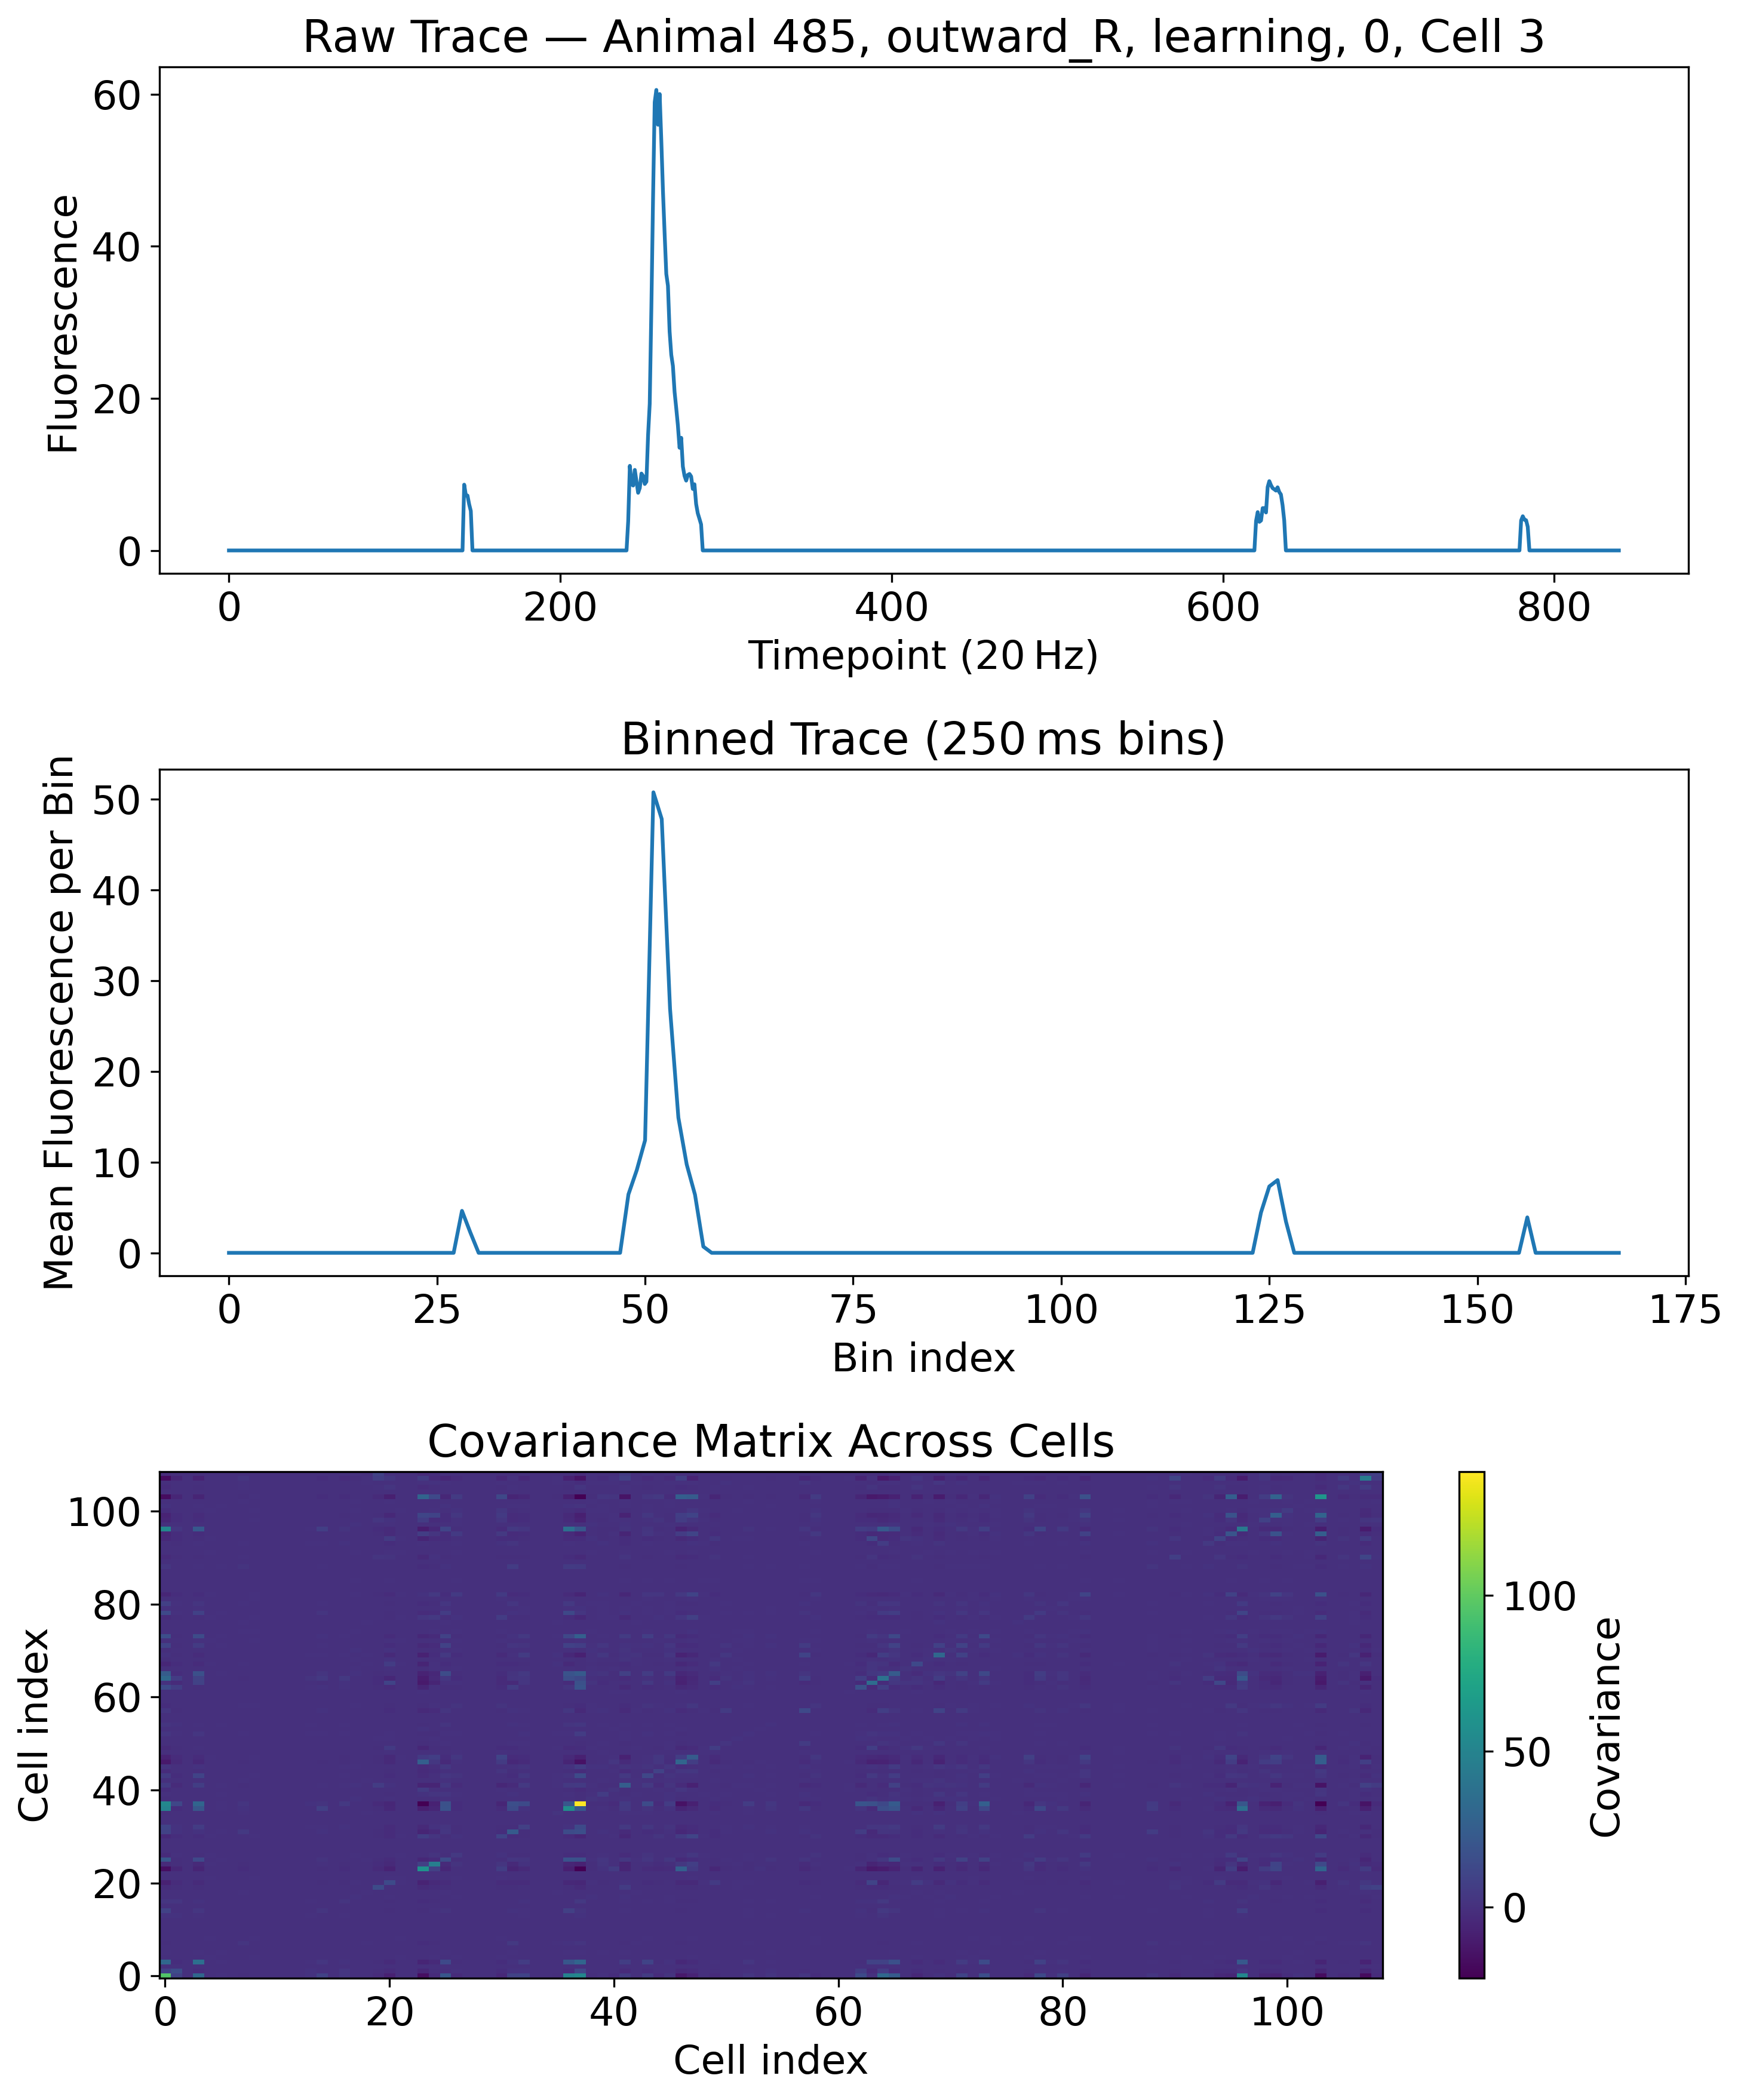

In [ ]:

raw     = entry['raw']      # (n_cells, n_timepoints)
binned  = entry['binned']   # (n_cells, n_bins)
cov_mat = entry['cov_mat']  # (n_cells, n_cells)

# 2) extract your example traces
raw_trace    = raw[cell_index, :]
binned_trace = binned[cell_index, :]

# 3) plot raw, binned, and covariance matrix
fig, axes = plt.subplots(3, 1, figsize=(10, 12))

# --- Raw trace ---
ax = axes[0]
ax.plot(raw_trace)
ax.set_title(
    f'Raw Trace — Animal {animal}, {condition}, {phase}, {trial_type}, Cell {cell_index}'
)
ax.set_xlabel('Timepoint (20 Hz)')
ax.set_ylabel('Fluorescence')

# --- Binned trace ---
ax = axes[1]
ax.plot(binned_trace)
ax.set_title('Binned Trace (250 ms bins)')
ax.set_xlabel('Bin index')
ax.set_ylabel('Mean Fluorescence per Bin')

# --- Covariance matrix heatmap ---
ax = axes[2]
im = ax.imshow(cov_mat, aspect='auto', origin='lower')
ax.set_title('Covariance Matrix Across Cells')
ax.set_xlabel('Cell index')
ax.set_ylabel('Cell index')
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Covariance')

plt.tight_layout()
plt.show()

In [ ]:
type_name='arena'

In [ ]:
sdfsdf

In [ ]:
list(cond_names.keys())[1]

'arena_outward_R'

In [ ]:
cond_names

{'arena_outward_L': 8,
 'arena_outward_R': 9,
 'arena_inward_L': 10,
 'arena_inward_R': 11}

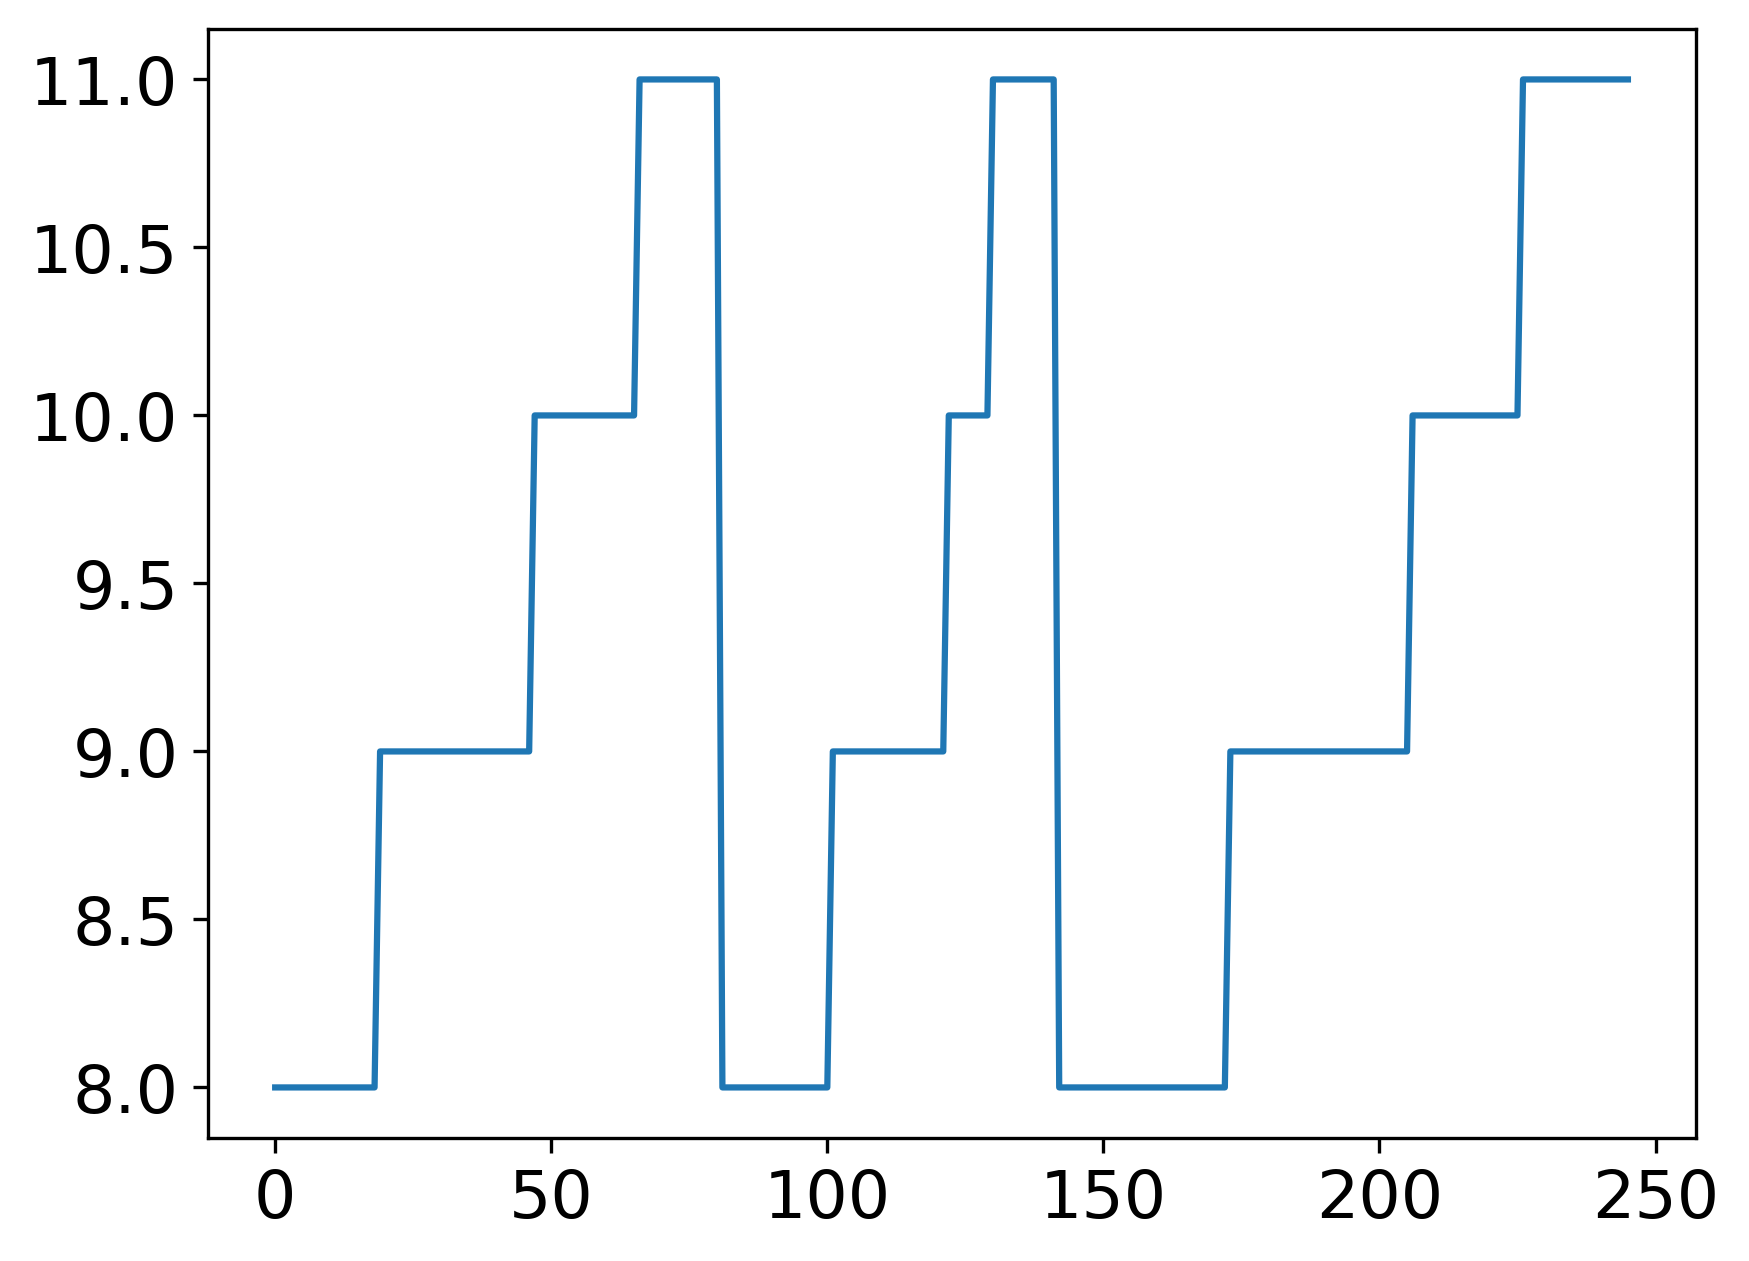

In [ ]:
plt.plot(Masks['bursts_cond'])

In [ ]:
data_all_tasks['sess_info']['id_peaks']

array([    4,    22,    47,    62,    94,   129,   140,   238,   253,
         264,   280,   384,   582,   598,   755,   766,   780,   793,
         806,   817,   915,   929,   945,   962,   974,  1049,  1060,
        1083,  1189,  1202,  1251,  1284,  1295,  1326,  1337,  1348,
        1359,  1373,  1399,  1413,  1427,  1444,  1467,  1550,  1571,
        1597,  1614,  1620,  1700,  1722,  1752,  1763,  1859,  1877,
        1947,  2016,  2040,  2389,  2416,  2439,  2500,  2536,  2579,
        2594,  2614,  2627,  2651,  2728,  2747,  2794,  2811,  2837,
        2866,  2887,  2997,  3166,  3256,  3269,  3364,  3379,  3448,
        3548,  3569,  3580,  3594,  3616,  3639,  3711,  3782,  3831,
        3883,  3935,  3974,  3985,  4090,  4110,  4122,  4213,  4323,
        4352,  4393,  4420,  4439,  4452,  4485,  4519,  4549,  4626,
        4737,  4765,  4919,  4947,  4971,  4990,  5097,  5223,  5289,
        5337,  5365,  5380,  5438,  5455,  5566,  5753,  5842,  6035,
        6115,  6131,

In [ ]:
cond_names

NameError: name 'cond_names' is not defined